<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.shape

(1460, 81)

#### Categorizing features into Fixed, Changeable and Sale Condition
- Classified ```BsmtQual``` as fixed because it is actually refers to the height of the basement
- ```BsmtExposure``` is also something I'd expect is not easy to renovate
- Categorized ```MiscFeature``` as fixed as the space to hold misc. features like tennis courts or swimming pools are more or less fixed as well. Can't really make space for it.

In [4]:
fixed = [
    'MSSubClass', 'MSZoning', 'BldgType','HouseStyle',
    'LotFrontage', 'LotArea', 'LotShape', 'LotConfig',
    'Street', 'Alley',
    'LandContour', 'LandSlope',
    'Utilities',
    'Neighborhood', 'Condition1', 'Condition2',
    'YearBuilt',
    'Foundation',
    'BsmtQual', 'BsmtExposure',
    'TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea', 
    'BsmtFullBath','BsmtHalfBath',
    'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd',
    'GarageType','GarageYrBlt','GarageCars','GarageArea',
    'MiscFeature','MiscVal',    
]

In [5]:
changeable = [
    'OverallQual','OverallCond',
    'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd','MasVnrType','MasVnrArea','ExterQual', 'ExterCond',
    'BsmtCond','BsmtFinType1','BsmtFinType2',
    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','LowQualFinSF',
    'Heating','HeatingQC','CentralAir', 'Electrical',
    'KitchenQual',
    'Functional',
    'Fireplaces','FireplaceQu',
    'GarageFinish','GarageQual','GarageCond',
    'PavedDrive', 
    'WoodDeckSF', 
    'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
    'PoolArea','PoolQC',
    'Fence' 
]

In [6]:
sale_conditions = [
    'SaleType',
    'SaleCondition',
    'MoSold',
    'YrSold',
    'YearRemodAdd'
]

Checking that all features have been categorized:

In [7]:
# id and SalePrice not included. Altogether 81.
len(fixed)+len(changeable)+len(sale_conditions)

79

#### Removing non-residential houses from the dataset
10 rows removed. New shape: (1450,81)

In [8]:
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [9]:
# dropping non-residential properties 
house.drop(house.index[house['MSZoning']=='C (all)'],inplace=True)

In [10]:
house['MSZoning'].value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [11]:
house.shape

(1450, 81)

## EDA

In [12]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-n

#### Handling Null Values
- Most of the null values are not missing values, but represent the absence of a property feature (e.g. no Fence)
    - Alley, Basement, Fireplace, Garage, Pool, Fence, MiscFeature
        - For these features, Null values to be replaced with a category label (e.g. No Basement)
    - Lot Frontage, Masonry Veneer, Electrical have null values that are less straightforward. Need to have a closer look before deciding what to do with the null values
    - Basement columns have 37 or 38 null values - need to investigate too

In [13]:
def check_column_nulls():
    for variable in house.columns:
        if house[variable].isnull().sum() > 0:
            print('{}: {} null values'.format(variable, house[variable].isnull().sum()))

check_column_nulls()

LotFrontage: 259 null values
Alley: 1361 null values
MasVnrType: 8 null values
MasVnrArea: 8 null values
BsmtQual: 37 null values
BsmtCond: 37 null values
BsmtExposure: 38 null values
BsmtFinType1: 37 null values
BsmtFinType2: 38 null values
Electrical: 1 null values
FireplaceQu: 681 null values
GarageType: 79 null values
GarageYrBlt: 79 null values
GarageFinish: 79 null values
GarageQual: 79 null values
GarageCond: 79 null values
PoolQC: 1443 null values
Fence: 1172 null values
MiscFeature: 1398 null values


#### Masonry Veneer
Where ```MasVnrType``` is null, so is ```MasVnrArea``` - consistent

In [14]:
house[house['MasVnrType'].isnull()][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


But strange that there are NaN values when there are categories for 'None' (```VasVnrType```) and 0 (```MasVnrArea```)

In [15]:
house['MasVnrArea'].value_counts().head()

0.0      851
72.0       8
180.0      8
108.0      8
120.0      7
Name: MasVnrArea, dtype: int64

In [16]:
house[house['MasVnrArea']==0][['MasVnrType','MasVnrArea']].head()

,MasVnrType,MasVnrArea
1,None,0.0
3,None,0.0
5,None,0.0
8,None,0.0
9,None,0.0


- No clear indications as to why these values are missing
- Will assume that this is a data entry error, and will change the NaN values to None and 0

In [17]:
# changing the NaN values to None and 0
def impute_masvnr():
    house['MasVnrType'].fillna('None',inplace=True)
    house['MasVnrArea'].fillna(0,inplace=True)

impute_masvnr()

In [18]:
house[house['MasVnrType'].isnull()][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea


In [19]:
check_column_nulls()

LotFrontage: 259 null values
Alley: 1361 null values
BsmtQual: 37 null values
BsmtCond: 37 null values
BsmtExposure: 38 null values
BsmtFinType1: 37 null values
BsmtFinType2: 38 null values
Electrical: 1 null values
FireplaceQu: 681 null values
GarageType: 79 null values
GarageYrBlt: 79 null values
GarageFinish: 79 null values
GarageQual: 79 null values
GarageCond: 79 null values
PoolQC: 1443 null values
Fence: 1172 null values
MiscFeature: 1398 null values


#### Basement

37 of the basement null values refer to properties with no basements, except for 1 (row index 948)

In [20]:
bsmt_cols = [col for col in house.columns if 'Bsmt' in col]
bsmt_null = house[house['BsmtExposure'].isnull()][bsmt_cols]

print('{} null rows'.format(len(bsmt_null)))
bsmt_null

38 null rows


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
39,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
90,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
102,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
156,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
182,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
259,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
342,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
362,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
371,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0


There are values for ```BasmtQual``` and ```BsmtCond```, but ```BsmtExposure``` indicates NaN("No Basement"). ```BsmtFinType1``` is also indicated as unfinished. Will drop this column as it is inconsistent and may affect the model.

In [21]:
bsmt_null[~bsmt_null['BsmtQual'].isnull()]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
948,Gd,TA,NaN,Unf,0,Unf,0,936,936,0,0


In [22]:
house.drop(948,inplace=True)

**To clean up basement columns:**
- Replace all NaN values in categorical Basement columns with 'NB' (No Basement)
- Will leave the numeric columns as 0

Noticed also that ```BsmtFinSF1``` + ```BsmtFinSF2``` + ```BsmtUnfSF``` = ```TotalBsmtSF```
- to be combined in 2nd iteration of model

In [23]:
house[bsmt_cols].head(2)

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
0,Gd,TA,No,GLQ,706,Unf,0,150,856,1,0
1,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,0,1


In [24]:
# separating categorical Basement columns
bsmt_cols_categorical = bsmt_cols[0:4] + [bsmt_cols[5]]
bsmt_cols_categorical

['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

In [25]:
def clean_basement_nulls():
    
    # Getting rid of all null values in categorical columns by assigning a new label 'NB'
    for col in bsmt_cols_categorical:
        if house[col].isnull().sum() > 0:
            house[col].fillna('NB',inplace=True)

clean_basement_nulls()

In [26]:
check_column_nulls()

LotFrontage: 259 null values
Alley: 1360 null values
Electrical: 1 null values
FireplaceQu: 681 null values
GarageType: 79 null values
GarageYrBlt: 79 null values
GarageFinish: 79 null values
GarageQual: 79 null values
GarageCond: 79 null values
PoolQC: 1442 null values
Fence: 1171 null values
MiscFeature: 1397 null values


In [27]:
# checking that NaN values were changed to 'NB"
len(house[bsmt_cols][house['BsmtQual']=='NB'])

37

#### Garage

In [28]:
garage_cols = [col for col in house.columns if 'Garage' in col]

In [29]:
house[garage_cols].head(2)

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Attchd,2003.0,RFn,2,548,TA,TA
1,Attchd,1976.0,RFn,2,460,TA,TA


All null values correspond to properties with no Garages

In [30]:
house[house['GarageType'].isnull()][garage_cols]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,NaN,NaN,NaN,0,0,NaN,NaN
48,NaN,NaN,NaN,0,0,NaN,NaN
78,NaN,NaN,NaN,0,0,NaN,NaN
89,NaN,NaN,NaN,0,0,NaN,NaN
99,NaN,NaN,NaN,0,0,NaN,NaN
108,NaN,NaN,NaN,0,0,NaN,NaN
125,NaN,NaN,NaN,0,0,NaN,NaN
127,NaN,NaN,NaN,0,0,NaN,NaN
140,NaN,NaN,NaN,0,0,NaN,NaN
148,NaN,NaN,NaN,0,0,NaN,NaN


For ```GarageYrBlt```, taking the median/mean to impute null values might not be as accurate. E.g. if the null value we're imputing for was a property built in 1980, but we just imputed the median of 1960. <br>
So we will just assume that the Garage was built together with the house (```GarageYrBlt``` = ```YearBuilt```) for null values

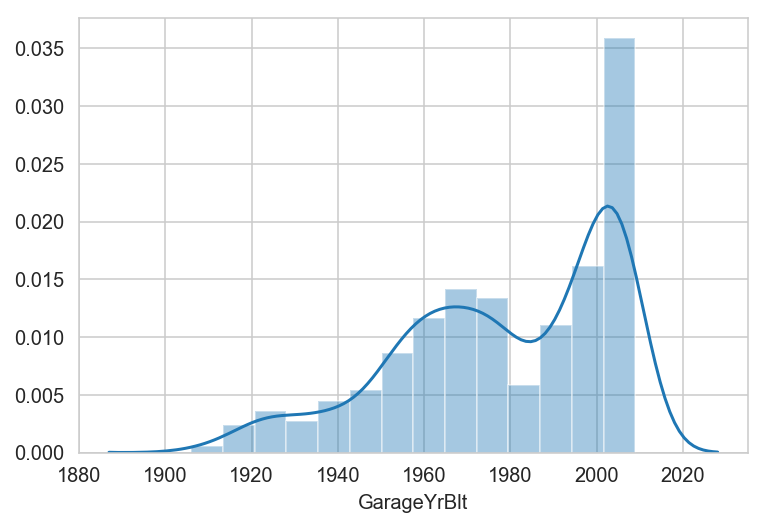

In [31]:
# in considering imputation for GarageYrBlt, data is skewed and seems to be more prevalent in later years
sns.distplot(house[(~house['GarageYrBlt'].isnull()) & (house['YrSold']!=2010)]['GarageYrBlt'])
plt.show()

In [32]:
def impute_garage_nulls():
    
    # excluding 'GarageYrBlt' as it is a numeric column
    # change all NaN values to No Garage
    for col in [garage_cols[0]] + garage_cols[2:]:
        if house[col].isnull().sum() > 0:
            house[col].fillna('NG',inplace=True)
    
    # assume that garage was built together with house
    house.loc[house['GarageYrBlt'].isnull(),'GarageYrBlt'] = house['YearBuilt']
    house['GarageYrBlt'] = house['GarageYrBlt'].apply(int)

impute_garage_nulls()

In [33]:
house[house['GarageType']=='NG'][garage_cols].head()

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,NG,1955,NG,0,0,NG,NG
48,NG,1920,NG,0,0,NG,NG
78,NG,1968,NG,0,0,NG,NG
89,NG,1994,NG,0,0,NG,NG
99,NG,1959,NG,0,0,NG,NG


In [34]:
check_column_nulls()

LotFrontage: 259 null values
Alley: 1360 null values
Electrical: 1 null values
FireplaceQu: 681 null values
PoolQC: 1442 null values
Fence: 1171 null values
MiscFeature: 1397 null values


#### Electrical

In [35]:
# seems like there is no clear reason why this row is null, will just drop
house[house['Electrical'].isnull()][['Utilities','Electrical','MSSubClass','BldgType','YearBuilt',
                                     'SaleCondition','Heating']]

,Utilities,Electrical,MSSubClass,BldgType,YearBuilt,SaleCondition,Heating
1379,AllPub,NaN,80,1Fam,2006,Normal,GasA


In [36]:
house['Electrical'].value_counts()

SBrkr    1327
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [37]:
house.drop(1379,inplace=True)

In [38]:
check_column_nulls()

LotFrontage: 259 null values
Alley: 1359 null values
FireplaceQu: 680 null values
PoolQC: 1441 null values
Fence: 1170 null values
MiscFeature: 1396 null values


#### Fireplace
All ```FireplaceQu``` null values have 0 ```Fireplaces``` - checks out

In [39]:
house[(house['FireplaceQu'].isnull()) & (house['Fireplaces']!=0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [40]:
def impute_fireplace_nulls():
    house['FireplaceQu'].fillna('NF',inplace=True)

impute_fireplace_nulls()

In [41]:
check_column_nulls()

LotFrontage: 259 null values
Alley: 1359 null values
PoolQC: 1441 null values
Fence: 1170 null values
MiscFeature: 1396 null values


#### Fence

In [42]:
def impute_fence_nulls():
    house['Fence'].fillna('NFence',inplace=True)
    
impute_fence_nulls()

In [43]:
check_column_nulls()

LotFrontage: 259 null values
Alley: 1359 null values
PoolQC: 1441 null values
MiscFeature: 1396 null values


#### Pool
All No Pool entries have a pool area of 0 - also checks out

In [44]:
house[(house['PoolQC'].isnull()) & (house['PoolArea']!=0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [45]:
def impute_pool_nulls():
    house['PoolQC'].fillna('NP',inplace=True)

impute_pool_nulls()

In [46]:
check_column_nulls()

LotFrontage: 259 null values
Alley: 1359 null values
MiscFeature: 1396 null values


#### MiscFeature

```MiscVal``` of 0 corresponds with NaN values in ```MiscFeature``` <br>
Will leave ```MiscVal``` as 0 as it is indeed $0 if there are no ```MiscFeature```

In [47]:
house[(house['MiscFeature'].isnull()) & (house['MiscVal']!=0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [48]:
def impute_misc_nulls():
    house['MiscFeature'].fillna('NM', inplace=True)

impute_misc_nulls()

In [49]:
check_column_nulls()

LotFrontage: 259 null values
Alley: 1359 null values


#### Alley

In [50]:
def impute_alley_nulls():
    house['Alley'].fillna('NA',inplace=True)
impute_alley_nulls()

In [51]:
check_column_nulls()

LotFrontage: 259 null values


#### Lot Frontage
Quite a sizable amount of nulls from Lot Frontage. No clear pattern why - will just impute with medians given the skewed distribution

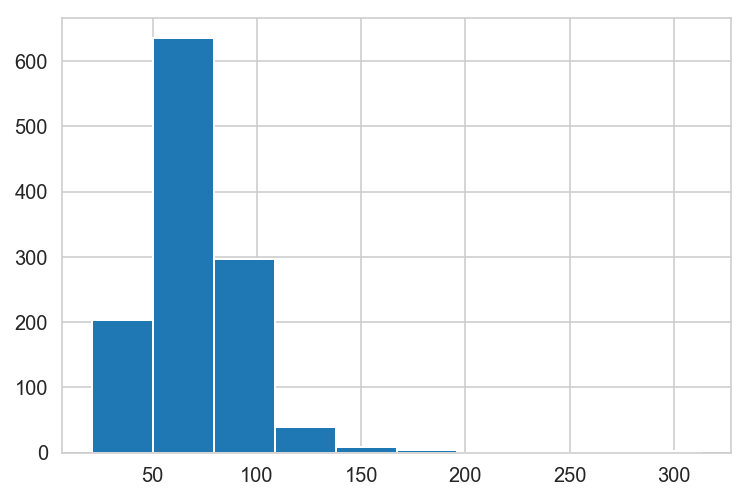

In [52]:
# right skewed distribution
house['LotFrontage'].hist()

In [53]:
def impute_lotfrontage_nulls_median():
    
    # new column to indicate that these lot frontage null values were imputed
    house['lot_frontage_null'] = pd.isnull(house['LotFrontage']).apply(lambda x: 1 if x else 0)
    
    # impute with median value BEFORE 2010 to prevent any data leakage
    lot_frontage_median = house[house['YrSold']!=2010]['LotFrontage'].median()
    house['LotFrontage'].fillna(lot_frontage_median,inplace=True)

impute_lotfrontage_nulls_median()

In [54]:
check_column_nulls()

### Feature Engineering

In [55]:
# create new feature on the age of the house
house['age'] = house['YrSold'] - house['YearBuilt']

In [56]:
# whether or not it was remodelled
house['remodelled'] = 1 - (house['YearBuilt'] == house['YearRemodAdd'])

In [57]:
house['yrs_since_remod'] = house['YrSold'] - house['YearRemodAdd']

In [58]:
# garage age, since we have age of the house
house['garage_age'] = house['YrSold'] - house['GarageYrBlt']

In [59]:
house[['YearBuilt','YearRemodAdd','YrSold','MoSold','GarageYrBlt',
       'remodelled','age','yrs_since_remod','garage_age']].sample(5)

,YearBuilt,YearRemodAdd,YrSold,MoSold,GarageYrBlt,remodelled,age,yrs_since_remod,garage_age
708,2007,2007,2007,7,2007,0,0,0,0
1237,2004,2005,2006,9,2004,1,2,1,2
431,1920,1998,2008,9,1920,1,88,10,88
1273,1959,2006,2008,5,1959,1,49,2,49
629,1964,1964,2008,6,1964,0,44,44,44


#### Checking out correlations:
- There are a couple of variables that have a higher positive correlation with ```SalePrice```:
    - To do with Space: ```LotFrontage```, ```LotArea```, ```TotalBsmtSF```, ```GrLivArea```, ```GarageArea```
    - Features: ```Fireplaces```, ```WoodDeckSF```
    - And also negatively correlated with ```age``` of the house

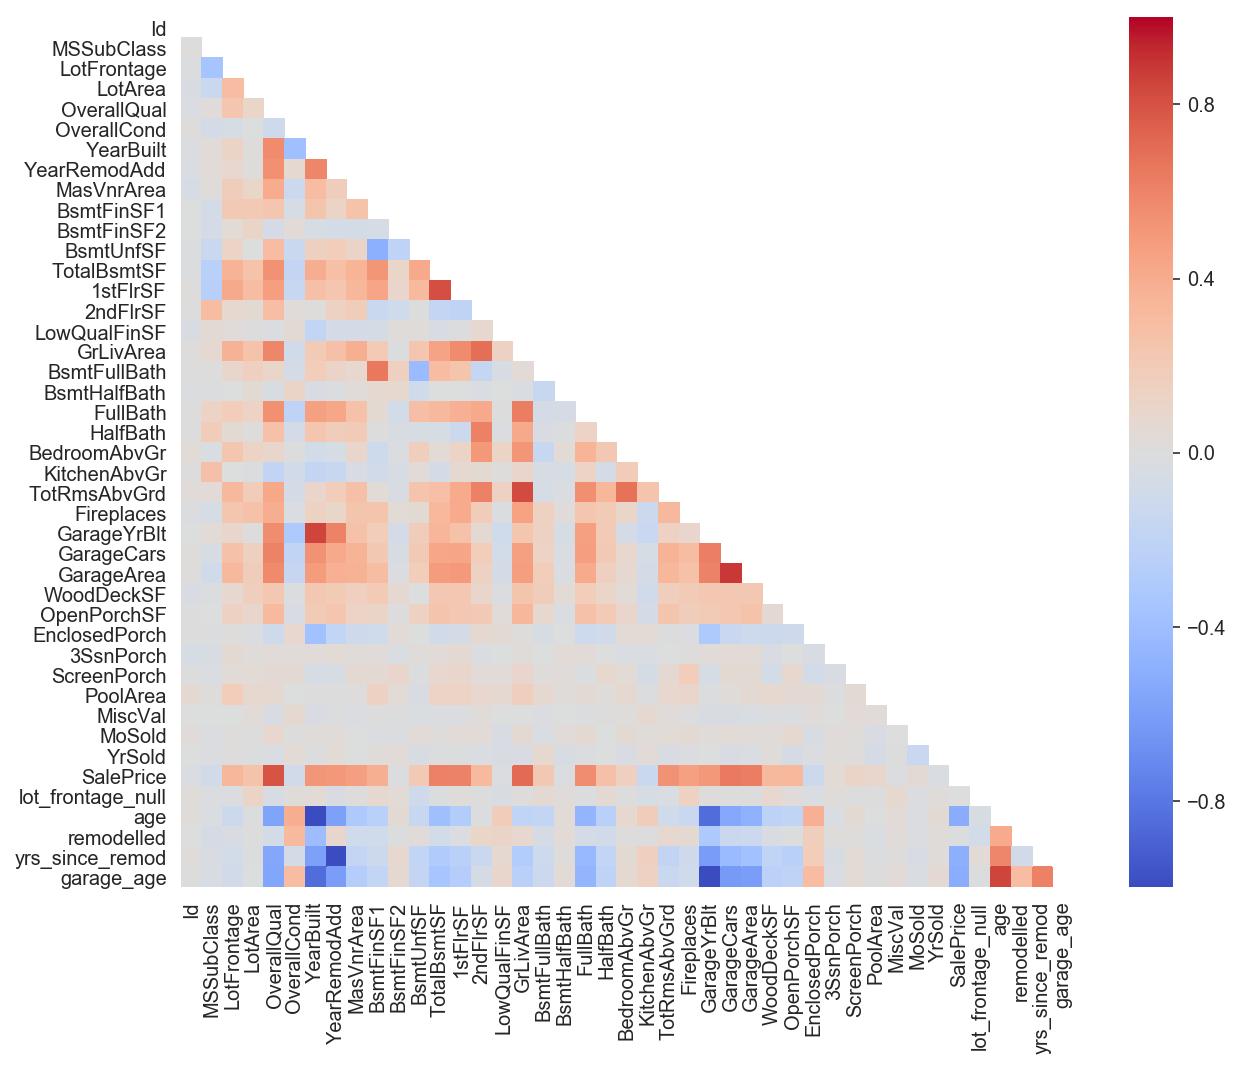

In [60]:
mask = np.zeros_like(house.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,8))
sns.heatmap(house.corr(),cmap='coolwarm',mask=mask)
plt.show()

### Preprocessing

#### Changing ```MSSubClass``` to string, to get dummies for model

In [61]:
house['MSSubClass'].dtype

dtype('int64')

In [62]:
house['MSSubClass'] = house['MSSubClass'].apply(str)
house['MSSubClass'].unique()

array(['60', '20', '70', '50', '190', '45', '90', '120', '30', '85', '80',
       '160', '75', '180', '40'], dtype=object)

#### Setting up df for fixed features

In [63]:
house.shape

(1448, 86)

In [64]:
# sorting values by year so that it's easy to split test and train later
house.sort_values(by='YrSold',inplace=True)

In [65]:
# reset index so that we won't run into indexing problems when modelling
house.reset_index(inplace=True, drop=True)

In [66]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [67]:
fixed_new_cols = ['lot_frontage_null', 'age', 'garage_age']

In [68]:
fixed.extend(fixed_new_cols)
fixed

['MSSubClass',
 'MSZoning',
 'BldgType',
 'HouseStyle',
 'LotFrontage',
 'LotArea',
 'LotShape',
 'LotConfig',
 'Street',
 'Alley',
 'LandContour',
 'LandSlope',
 'Utilities',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'YearBuilt',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'GarageType',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'MiscFeature',
 'MiscVal',
 'lot_frontage_null',
 'age',
 'garage_age']

In [69]:
len(fixed)

40

In [70]:
house_fixed = pd.concat([house[fixed],house[['SalePrice']]],axis=1)

In [71]:
house_fixed.columns

Index(['MSSubClass', 'MSZoning', 'BldgType', 'HouseStyle', 'LotFrontage',
       'LotArea', 'LotShape', 'LotConfig', 'Street', 'Alley', 'LandContour',
       'LandSlope', 'Utilities', 'Neighborhood', 'Condition1', 'Condition2',
       'YearBuilt', 'Foundation', 'BsmtQual', 'BsmtExposure', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'MiscFeature',
       'MiscVal', 'lot_frontage_null', 'age', 'garage_age', 'SalePrice'],
      dtype='object')

In [72]:
house_fixed.shape

(1448, 41)

#### Get dummies

In [73]:
dummy_columns = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour',
                 'Utilities','LotConfig','LandSlope','Neighborhood','Condition1',
                 'Condition2','BldgType','HouseStyle','Foundation','BsmtQual',
                 'BsmtExposure','GarageType','MiscFeature']

In [74]:
fixed_dummies = pd.get_dummies(house_fixed[dummy_columns],drop_first=True)

In [75]:
house_fixed = pd.concat([house_fixed,fixed_dummies],axis=1)

In [76]:
house_fixed.drop(dummy_columns,axis=1,inplace=True)

In [77]:
for col in house_fixed.columns:
    print(col)

LotFrontage
LotArea
YearBuilt
TotalBsmtSF
1stFlrSF
2ndFlrSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
GarageYrBlt
GarageCars
GarageArea
MiscVal
lot_frontage_null
age
garage_age
SalePrice
MSSubClass_160
MSSubClass_180
MSSubClass_190
MSSubClass_20
MSSubClass_30
MSSubClass_40
MSSubClass_45
MSSubClass_50
MSSubClass_60
MSSubClass_70
MSSubClass_75
MSSubClass_80
MSSubClass_85
MSSubClass_90
MSZoning_RH
MSZoning_RL
MSZoning_RM
Street_Pave
Alley_NA
Alley_Pave
LotShape_IR2
LotShape_IR3
LotShape_Reg
LandContour_HLS
LandContour_Low
LandContour_Lvl
Utilities_NoSeWa
LotConfig_CulDSac
LotConfig_FR2
LotConfig_FR3
LotConfig_Inside
LandSlope_Mod
LandSlope_Sev
Neighborhood_Blueste
Neighborhood_BrDale
Neighborhood_BrkSide
Neighborhood_ClearCr
Neighborhood_CollgCr
Neighborhood_Crawfor
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_IDOTRR
Neighborhood_MeadowV
Neighborhood_Mitchel
Neighborhood_NAmes
Neighborhood_NPkVill
Neighborhood_NWAmes
Neighborhoo

In [78]:
house_fixed.shape

(1448, 128)

#### Segment train and test data
Split data between Pre-2010 (Train) and 2010 (Test)

In [79]:
house['YrSold'].value_counts()

2009    336
2007    328
2006    311
2008    301
2010    172
Name: YrSold, dtype: int64

In [80]:
house_fixed[house['YrSold']==2010].head(2)

,LotFrontage,LotArea,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,...,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NG,MiscFeature_NM,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
1276,36.0,2628,2003,764,764,862,1626,0,0,2,...,0,0,1,0,0,0,1,0,0,0
1277,44.0,9548,2003,941,941,888,1829,1,0,2,...,1,0,0,0,0,0,1,0,0,0


In [81]:
# because df was sorted and reindexed earlier, I can just slice by the 1276th row
X_train = house_fixed[:1276].drop('SalePrice',axis=1)
y_train = house_fixed[:1276]['SalePrice']
X_test = house_fixed[1276:].drop('SalePrice',axis=1)
y_test = house_fixed[1276:]['SalePrice']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1276, 127)
(1276,)
(172, 127)
(172,)


## Modelling

In [82]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [83]:
ss = StandardScaler()
Xs_fixed_train = ss.fit_transform(X_train)
Xs_fixed_test = ss.transform(X_test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:
Xs_fixed_train = pd.DataFrame(Xs_fixed_train, columns=X_train.columns)
Xs_fixed_test = pd.DataFrame(Xs_fixed_test, columns=X_train.columns)

### Base Model \#1: 
**OLS + dumping all variables in**
- Pretty decent for a model that was created from dumping everything in. 
- Test score is close to train score of $R^2$ 0.86
- However, ```cross_val_score``` has quite a bit of variance and the mean score is lower than my train and test scores. 
    - This suggests some overfitting on my training data as it does not perform as well when the training data is sliced up. 
    - The scores in some folds go as low as 0.70 and 0.51
    
Note: cross_val_score is a little cranky - the $R^2$ scores sometimes look normal, but go up to billions other times

In [85]:
def print_cv_scores(cv_scores):
    print('R2 Scores: {}'.format(cv_scores))
    print('Avg R2Score: {:.5f}'.format(cv_scores.mean()))
    print('R2 Score Std.: {:.5f}'.format(cv_scores.std()))

In [86]:
cv_scores_ols = cross_val_score(LinearRegression(),Xs_fixed_train,y_train,cv=5)
print_cv_scores(cv_scores_ols)

R2 Scores: [0.86958992 0.69834308 0.51069617 0.83196507 0.80308038]
Avg R2Score: 0.74273
R2 Score Std.: 0.12923


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [87]:
lm_ols = LinearRegression()
lm_ols.fit(Xs_fixed_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [88]:
lm_ols_preds = lm_ols.predict(Xs_fixed_test)

In [89]:
lm_ols.score(Xs_fixed_test, y_test)

0.8639008383276041

In [90]:
cv_r2_scores = [round(num,3) for num in cv_scores_ols]
cv_mean_r2_scores = cv_scores_ols.mean()
cv_std_r2_scores = cv_scores_ols.std()

test_r2_score = lm_ols.score(Xs_fixed_test,y_test)
test_rmse = np.sqrt(mean_squared_error(y_test,lm_ols_preds))
train_r2_scores = lm_ols.score(Xs_fixed_train,y_train)

models_eval = pd.DataFrame({
    'Model': 'OLS, filled null values',
    'CV r2 Scores': [cv_r2_scores],
    'CV Mean r2 Score': cv_mean_r2_scores,
    'CV Std r2 Score': cv_std_r2_scores,
    'Test Score (r2)': test_r2_score,
    'Test RMSE': test_rmse,
    'Train Score (r2)': train_r2_scores
}, columns=['Model','CV Mean r2 Score','CV Std r2 Score','Test Score (r2)', 
            'Test RMSE','CV r2 Scores','Train Score (r2)'])

models_eval

,Model,CV Mean r2 Score,CV Std r2 Score,Test Score (r2),Test RMSE,CV r2 Scores,Train Score (r2)
0,"OLS, filled null values",0.742735,0.129235,0.863901,29414.905885,"[0.87, 0.698, 0.511, 0.832, 0.803]",0.861932


In [91]:
lm_ols_coef = pd.DataFrame({
    'coefficients': lm_ols.coef_,
    'mag': abs(lm_ols.coef_),
    'variables': X_train.columns
})

Printing out the coefficients to have a look - 
- It includes some unlikely variables like miscfeatures as top coefficients. But we'll see if this persists in subsequent models
- But also includes some of the features we observed earlier as being strongly correlatd with ```SalePrice``` like ```GrLivArea``` and ```Garage```

In [92]:
lm_ols_coef.sort_values(by='mag',ascending=False)

,coefficients,mag,variables
123,42840.351479,42840.351479,MiscFeature_NM
125,39263.817774,39263.817774,MiscFeature_Shed
110,-21116.859102,21116.859102,BsmtQual_Gd
6,19981.162391,19981.162391,GrLivArea
112,-19707.431322,19707.431322,BsmtQual_TA
5,19684.798535,19684.798535,2ndFlrSF
117,15081.684514,15081.684514,GarageType_Attchd
121,12915.686630,12915.686630,GarageType_Detchd
69,11772.793034,11772.793034,Neighborhood_NridgHt
15,11325.776453,11325.776453,GarageCars


### Model \#2: Lasso
Use to reduce the number of features

In [93]:
lm_lasso = LassoCV(n_alphas=100,cv=10)

In [94]:
lm_lasso.fit(Xs_fixed_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [95]:
lm_lasso.score(Xs_fixed_train, y_train)

0.8527198632197265

In [96]:
lm_lasso.score(Xs_fixed_test,y_test)

0.87184848732377

In [97]:
lm_lasso_preds = lm_lasso.predict(Xs_fixed_test)

In [98]:
lm_lasso.alpha_

560.3762528018129

In [99]:
cv_scores_lasso = cross_val_score(Lasso(alpha=lm_lasso.alpha_), Xs_fixed_train, y_train,cv=5)

In [100]:
cv_r2_scores = [round(num,3) for num in cv_scores_lasso]
cv_mean_r2_scores = cv_scores_lasso.mean()
cv_std_r2_scores = cv_scores_lasso.std()

models_eval.loc[1,'Model'] = 'Lasso, filled null values'
models_eval.loc[1,'CV Mean r2 Score'] = cv_mean_r2_scores
models_eval.loc[1,'CV Std r2 Score'] = cv_std_r2_scores
models_eval.loc[1,'Test Score (r2)'] = lm_lasso.score(Xs_fixed_test,y_test)
models_eval.loc[1,'Test RMSE'] = np.sqrt(mean_squared_error(y_test,lm_lasso_preds))
models_eval.at[1,'CV r2 Scores'] = cv_r2_scores
models_eval.loc[1, 'Train Score (r2)'] = lm_lasso.score(Xs_fixed_train, y_train)

models_eval

,Model,CV Mean r2 Score,CV Std r2 Score,Test Score (r2),Test RMSE,CV r2 Scores,Train Score (r2)
0,"OLS, filled null values",0.742735,0.129235,0.863901,29414.905885,"[0.87, 0.698, 0.511, 0.832, 0.803]",0.861932
1,"Lasso, filled null values",0.775274,0.125375,0.871848,28543.130726,"[0.879, 0.761, 0.538, 0.855, 0.843]",0.852720


- Lasso model is sliiightly better in terms of test $R^2$, cross val scores are still seeing pretty big variances
- In terms of coefficients, we see that Misc Features are no longer one of the top coefficients

In [101]:
lm_lasso_coef = pd.DataFrame({
    'coefficients': lm_lasso.coef_,
    'mag': abs(lm_lasso.coef_),
    'variables': X_train.columns
})
lm_lasso_coef.sort_values(by='mag',ascending=False)

,coefficients,mag,variables
6,32797.087017,32797.087017,GrLivArea
110,-16401.022185,16401.022185,BsmtQual_Gd
112,-15678.501859,15678.501859,BsmtQual_TA
69,12470.966233,12470.966233,Neighborhood_NridgHt
68,9721.908865,9721.908865,Neighborhood_NoRidge
15,9439.032087,9439.032087,GarageCars
2,8556.679513,8556.679513,YearBuilt
75,7555.973467,7555.973467,Neighborhood_StoneBr
12,-6159.450009,6159.450009,KitchenAbvGr
74,5936.400774,5936.400774,Neighborhood_Somerst


In [102]:
lasso_eliminated_features = lm_lasso_coef[lm_lasso_coef['mag']==0]['variables'].values
lasso_eliminated_features

array(['1stFlrSF', '2ndFlrSF', 'GarageYrBlt', 'GarageArea', 'MiscVal',
       'lot_frontage_null', 'garage_age', 'MSSubClass_190',
       'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60',
       'MSSubClass_70', 'MSSubClass_75', 'MSZoning_RH', 'MSZoning_RL',
       'Alley_Pave', 'LotShape_Reg', 'LandContour_Low',
       'LotConfig_Inside', 'LandSlope_Mod', 'Neighborhood_Blueste',
       'Neighborhood_IDOTRR', 'Neighborhood_Timber', 'Condition1_PosA',
       'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn',
       'Condition2_Feedr', 'Condition2_Norm', 'Condition2_RRAn',
       'Condition2_RRNn', 'BldgType_2fmCon', 'HouseStyle_1Story',
       'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story',
       'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'Foundation_CBlock',
       'Foundation_Stone', 'Foundation_Wood', 'GarageType_Attchd',
       'GarageType_Basment', 'MiscFeature_NM', 'MiscFeature_Othr',
       'MiscFeature_Shed', 'MiscFeature_TenC'], dtype=object

Couple more things we can do to try and improve the model:
- Remove outliers
- Perform log transformations on variables that are very skewed

### Checking for Outliers

In [103]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(20,10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=30,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout() 
    plt.show()

In [104]:
numeric_cols = []
for col in house.columns:
    if house[col].dtype != 'O':
        numeric_cols.append(col)

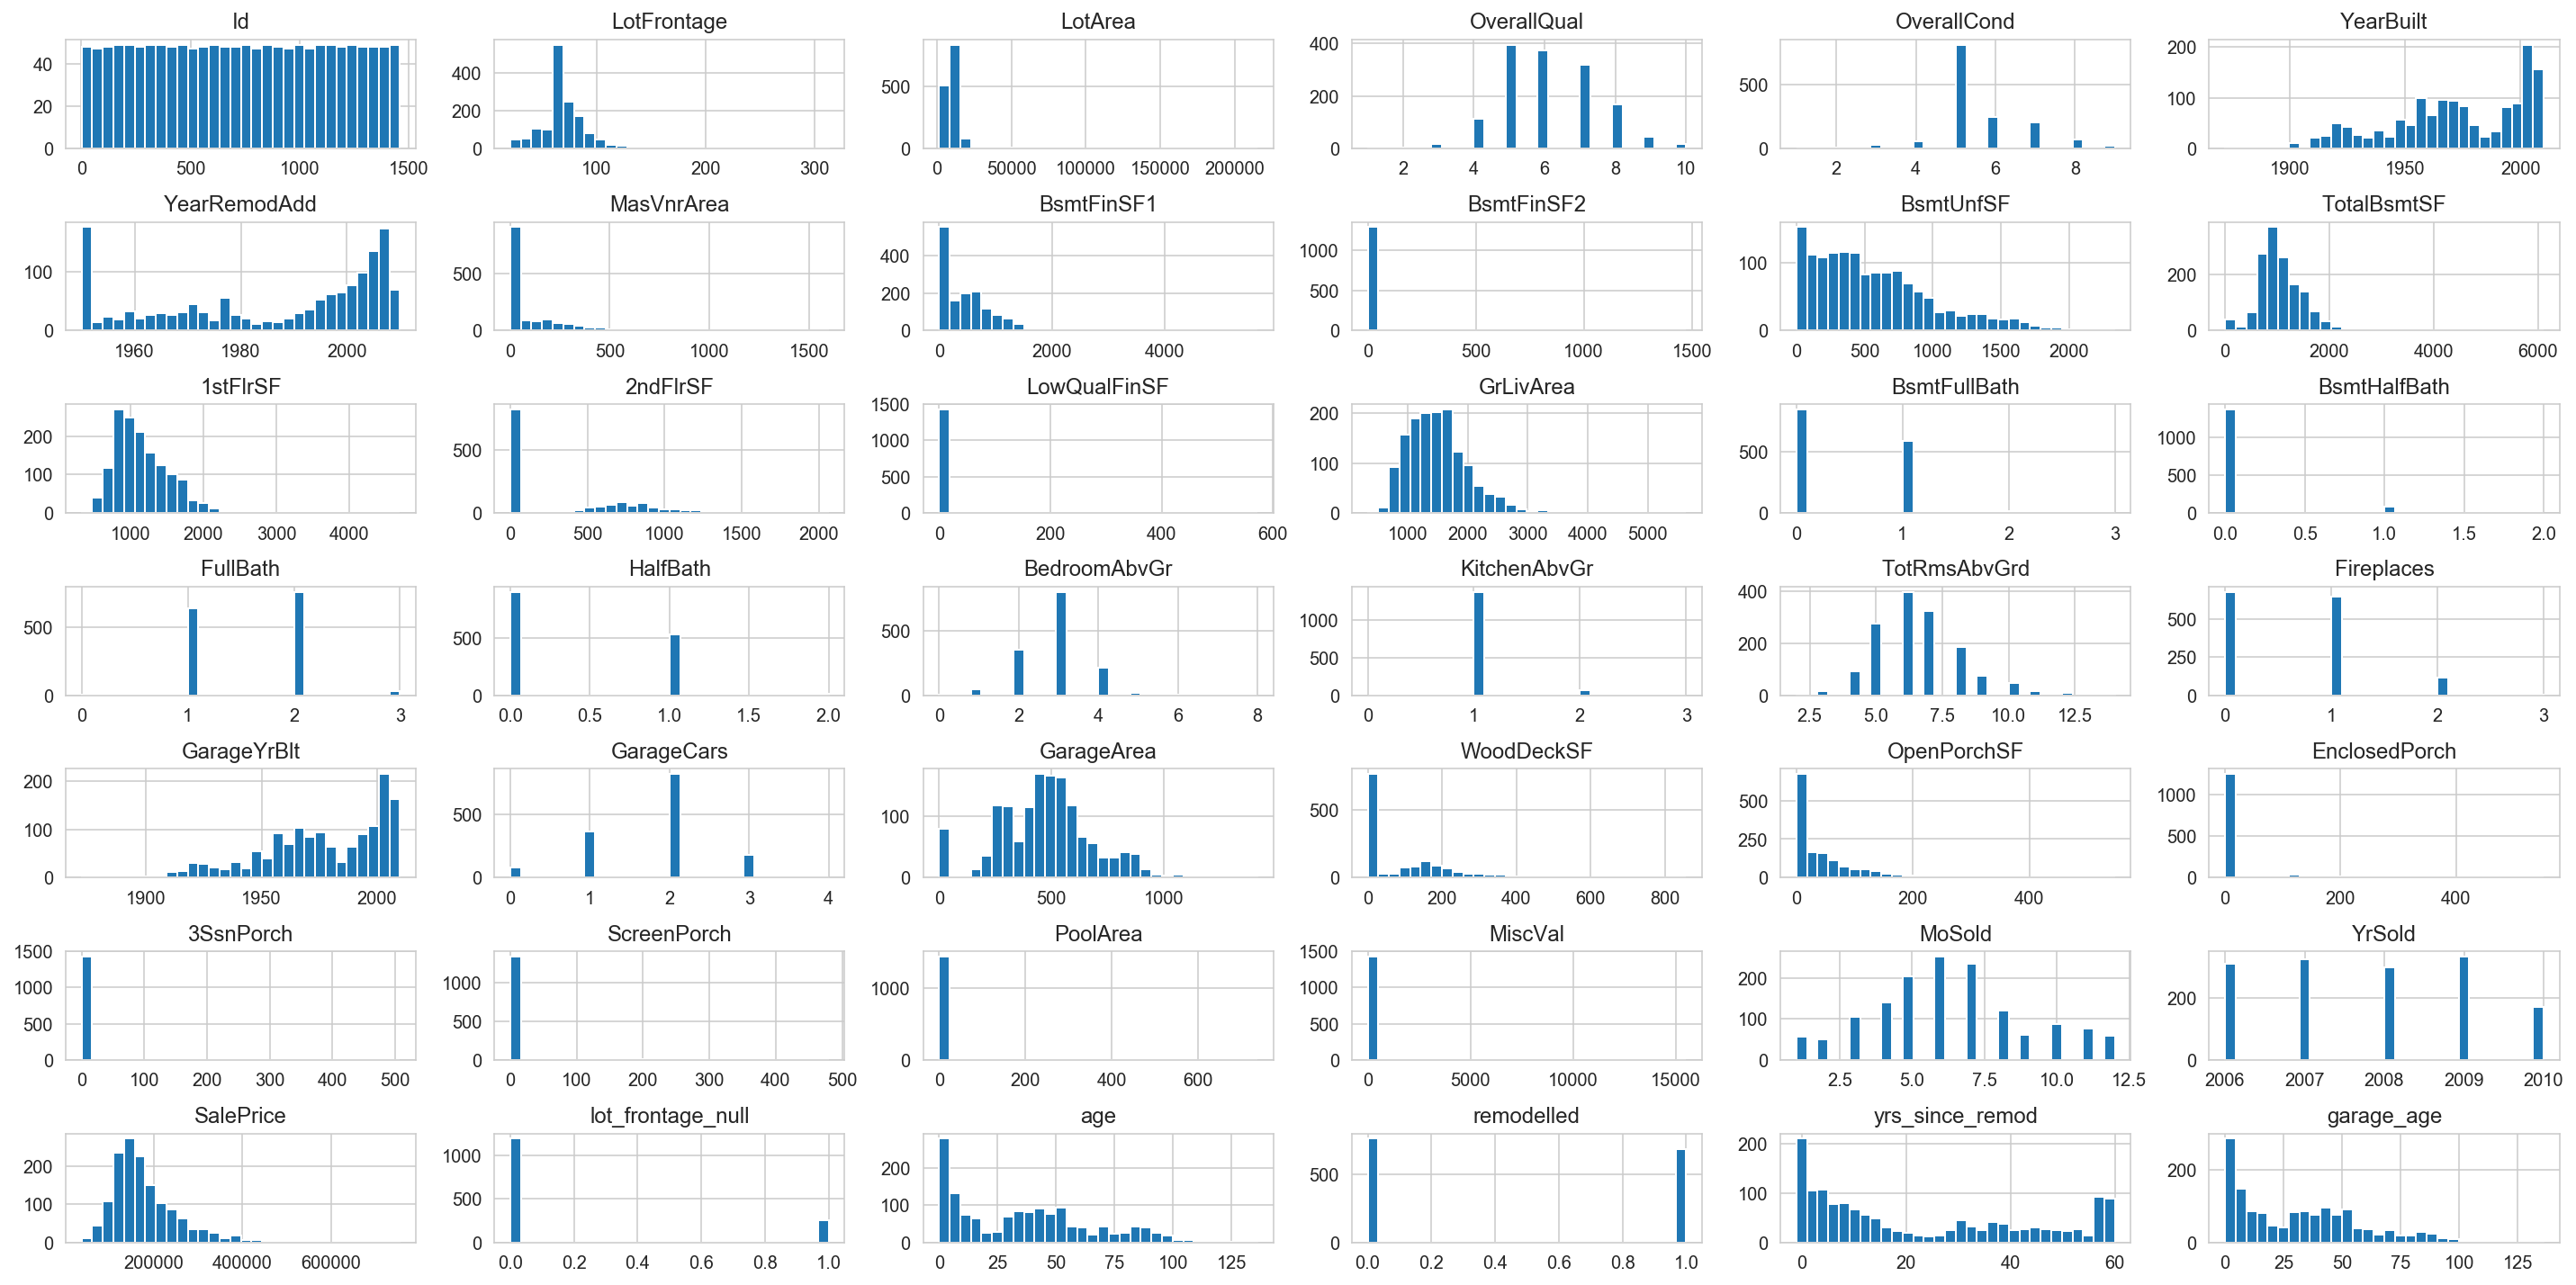

In [105]:
draw_histograms(house,numeric_cols,7,6)

#### Lot Frontage

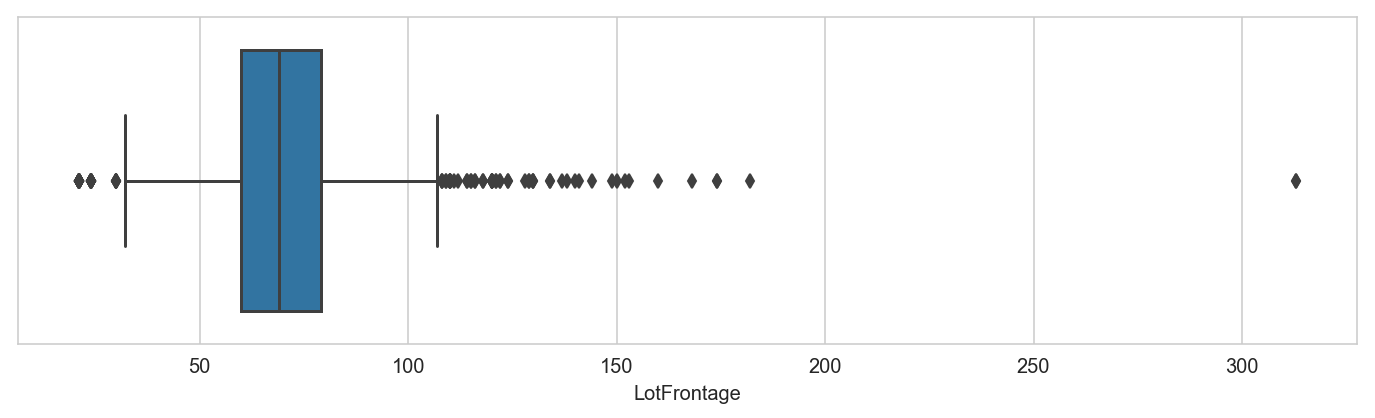

In [106]:
plt.figure(figsize=(12,3))
sns.boxplot('LotFrontage',data=house)

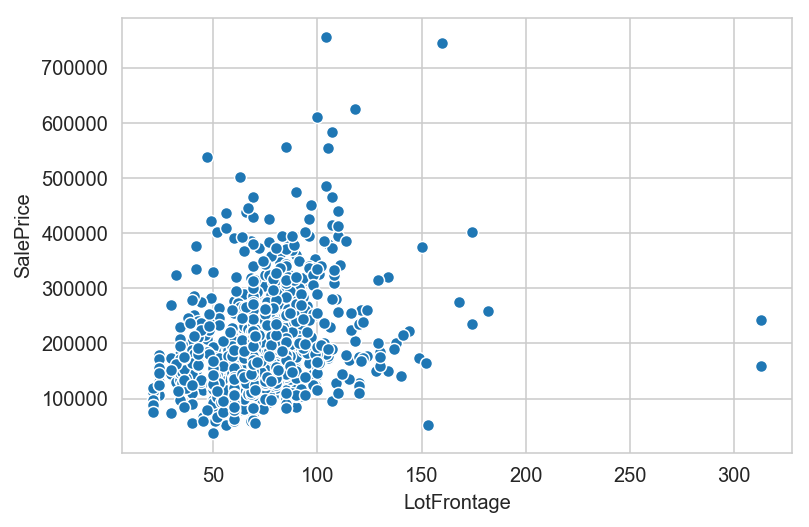

In [107]:
sns.scatterplot(x='LotFrontage',y='SalePrice',data=house)

In [108]:
# there are outliers at Lot Frontage > 300. let's take a closer look
house[house['LotFrontage']>300].index

Int64Index([674, 739], dtype='int64')

In [109]:
house.shape

(1448, 86)

In [110]:
# drop lot frontage outliers:
house.drop(house[house['LotFrontage']>300].index,inplace=True)
house.shape

(1446, 86)

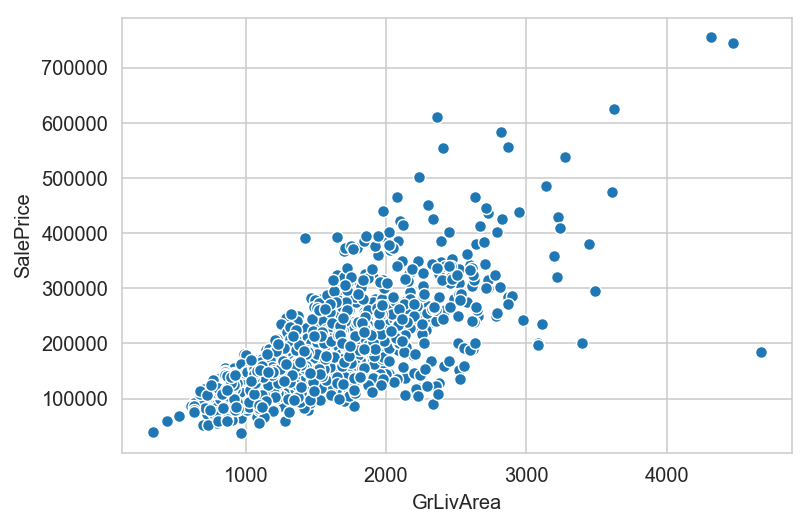

In [111]:
sns.scatterplot(x='GrLivArea',y='SalePrice',data=house)

In [112]:
# drop GrLivArea outlier
house.drop(house[(house['SalePrice']<200000) & (house['GrLivArea']>4000)].index,inplace=True)
house.shape

(1445, 86)

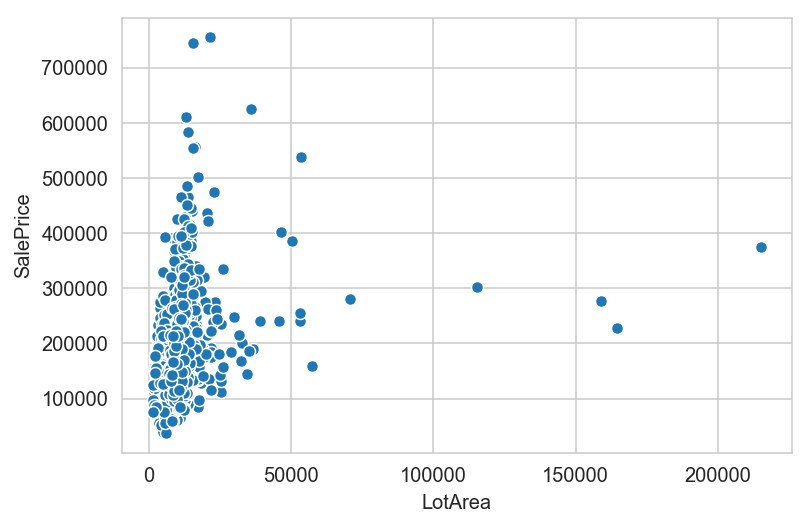

In [113]:
sns.scatterplot(x='LotArea',y='SalePrice',data=house)

In [114]:
# drop LotArea outlier
house.drop(house[house['LotArea']>150000].index,inplace=True)
house.shape

(1442, 86)

From the grid above, it is evident that there are a lot of skewed distributions. As in ```SalePrice``` below, they could benefit from log transformations

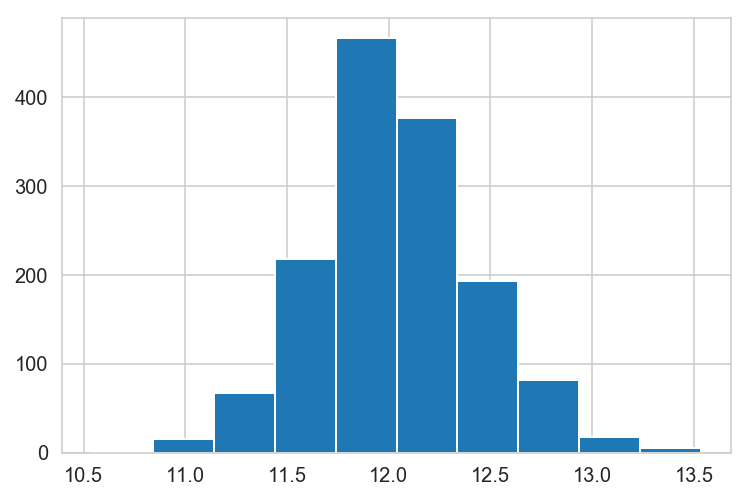

In [115]:
np.log1p(house['SalePrice']).hist()

#### Before we log transform - take a look if we can combine some columns containing sqft and see if that improves scores

In [116]:
sf_cols = [col for col in house.columns if 'SF' in col]

In [117]:
house[sf_cols].head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,WoodDeckSF,OpenPorchSF
0,387,0,374,761,810,793,0,0,124
1,300,294,468,1062,1352,0,0,168,0
2,1387,0,543,1930,1831,1796,0,361,76
3,388,0,552,940,1192,403,0,0,0
4,523,0,448,971,971,0,0,0,0


```TotalBsmtSF``` = ```BsmtFinSF1``` + ```BsmtFinSF2``` + ```BsmtUnfSF``` <br>
```GrLivArea``` = ```1stFlrSF``` + ```2ndFlrSF``` + ```LowQualFinSF```

In [118]:
np.all(house['BsmtFinSF1'] + house['BsmtFinSF2'] + house['BsmtUnfSF'] == house['TotalBsmtSF'])

True

In [119]:
np.all(house['1stFlrSF'] + house['2ndFlrSF'] + house['LowQualFinSF'] == house['GrLivArea'])

True

As these values are a subset of a more holistic variables, will drop the constituent variables

In [120]:
fixed = [col for col in fixed if col not in ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                                             '1stFlrSF','2ndFlrSF','LowQualFinSF']]

### Log Transformation

In [121]:
house_logtransform = house.copy()

In [122]:
to_transform = ['LotFrontage','LotArea','MasVnrArea','GrLivArea','TotRmsAbvGrd','GarageArea','WoodDeckSF',
                'OpenPorchSF','EnclosedPorch','ScreenPorch','SalePrice']

In [123]:
for col in to_transform:
    house_logtransform[col] = np.log1p(house_logtransform[col])

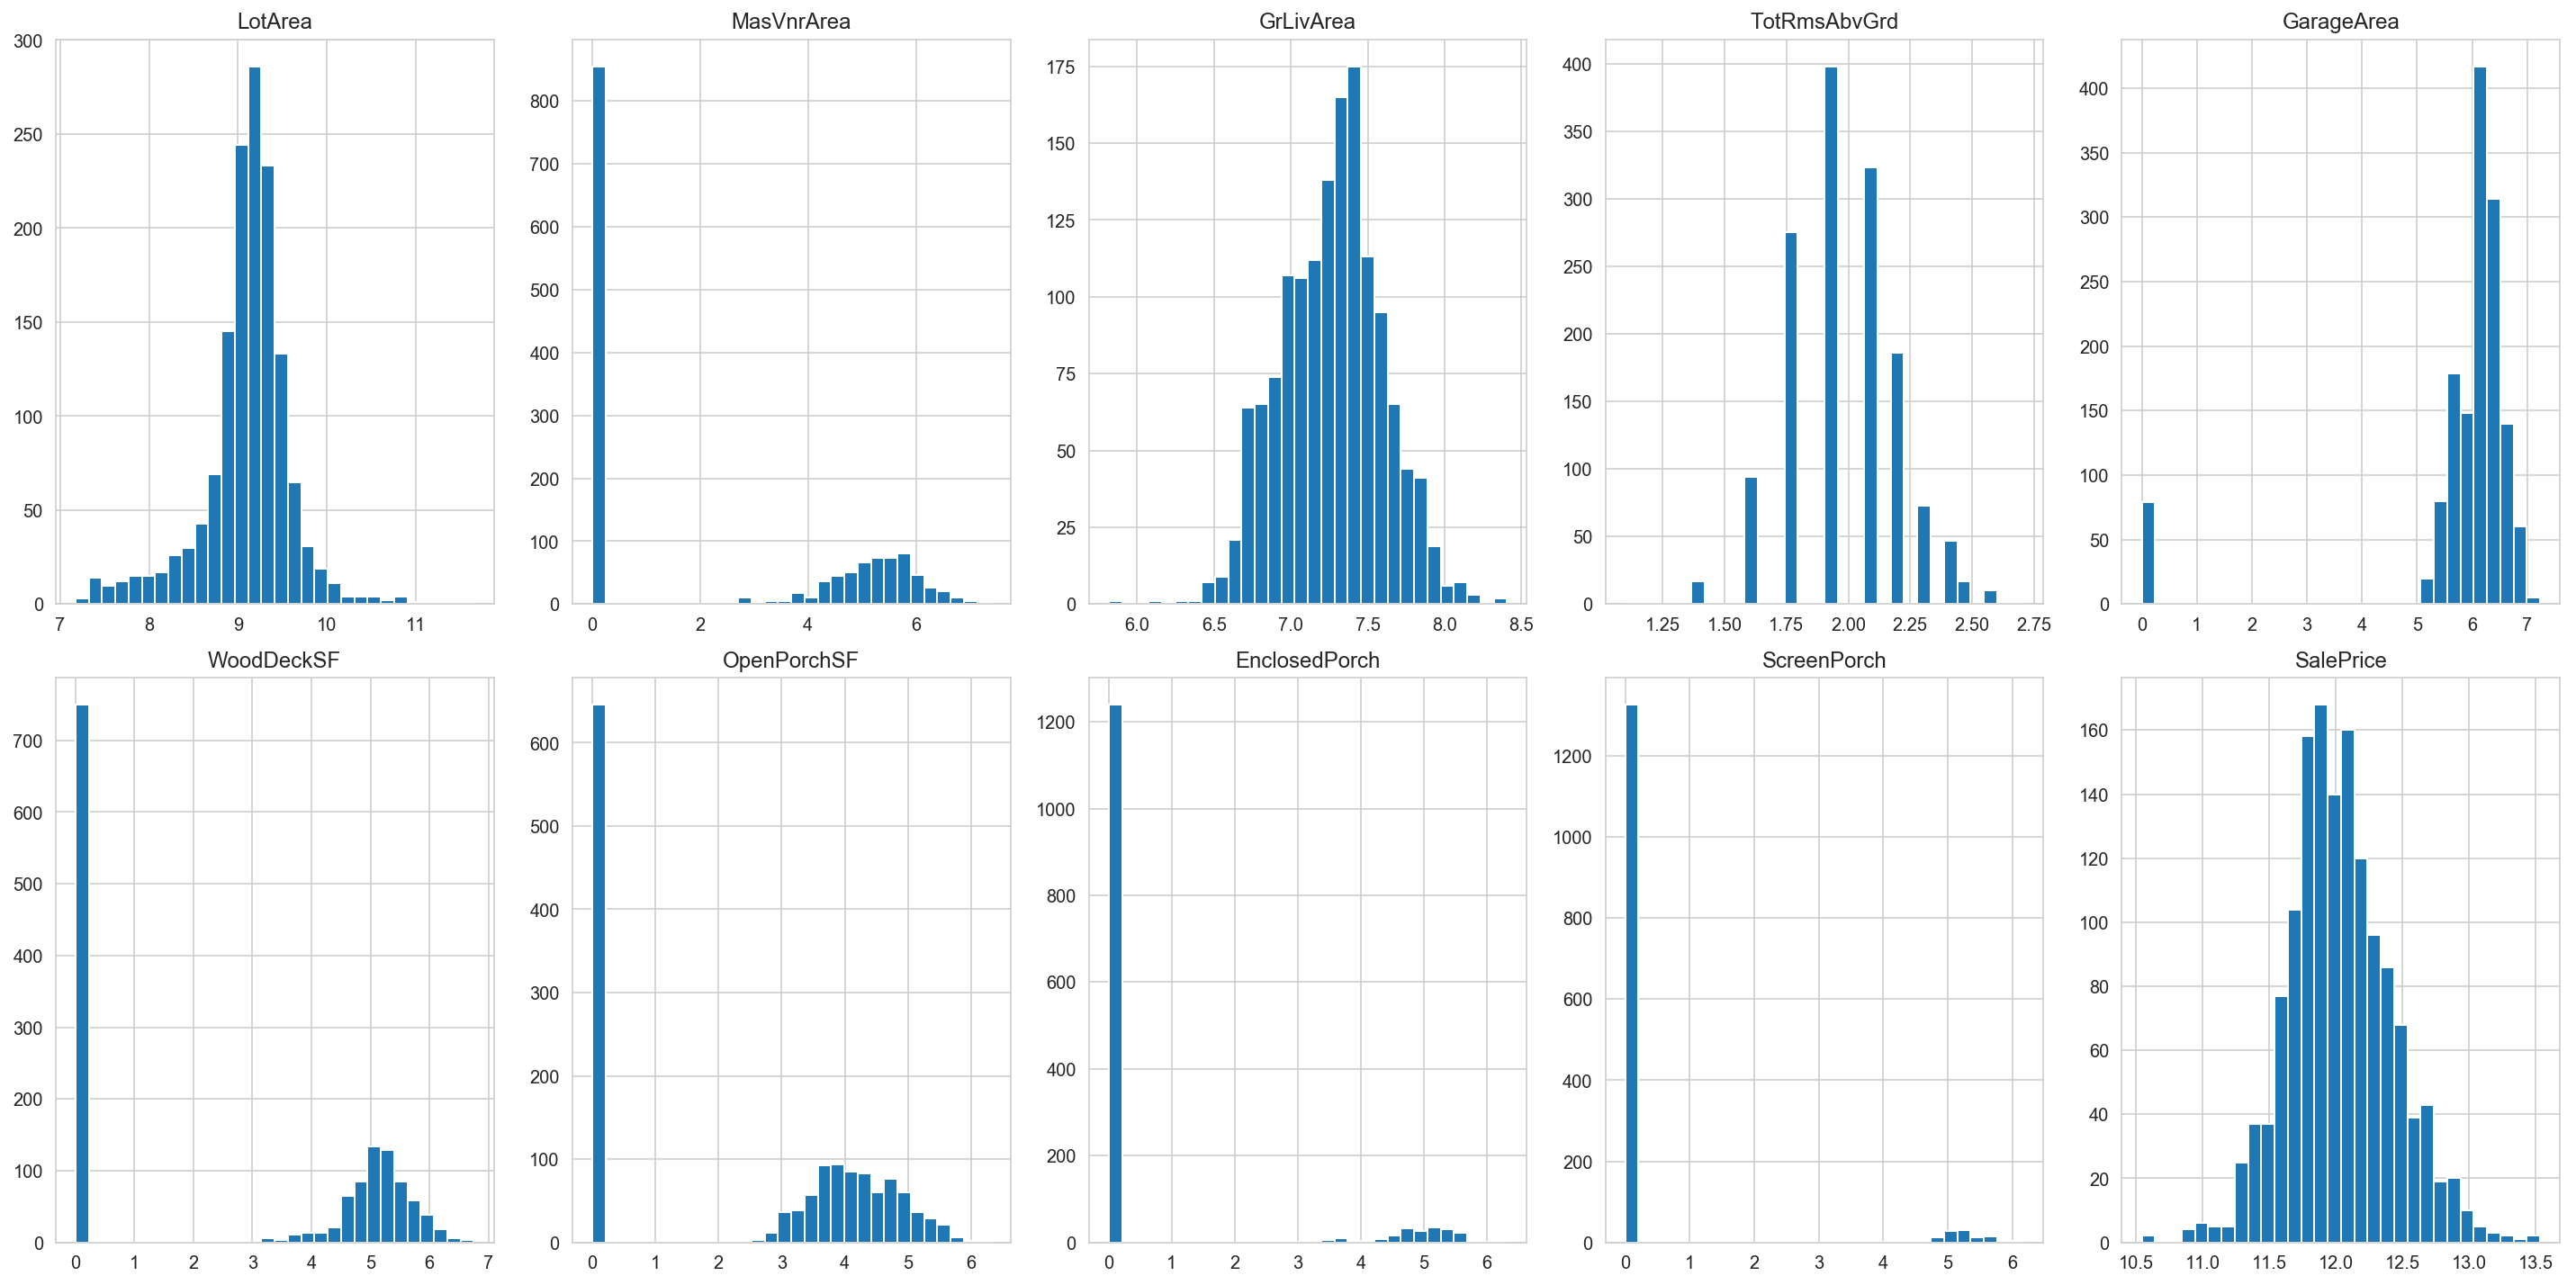

In [124]:
draw_histograms(house_logtransform,to_transform[1:],2,5)

#### Get dummies and train/test data

In [125]:
house_fixed.shape

(1448, 128)

In [126]:
house_logtransform.shape

(1442, 86)

In [127]:
house_fixed_2 = house_logtransform.copy()

# sort and reset index for the same reasons before
house_fixed_2.sort_values(by='YrSold',inplace=True)
house_fixed_2.reset_index(inplace=True)

In [128]:
# slice from row 1270 for train
house_fixed_2[house_fixed_2['YrSold']==2010].head(2)

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice,lot_frontage_null,age,remodelled,yrs_since_remod,garage_age
1270,1391,635,90,RL,4.174387,8.850804,Pave,NA,Reg,Lvl,...,6,2010,WD,Normal,11.877576,0,30,0,30,30
1271,1386,616,85,RL,4.394449,9.082621,Pave,NA,Reg,Lvl,...,5,2010,WD,Abnorml,11.831386,0,47,0,47,47


In [129]:
# adding target variable to new df
house_fixed_2 = pd.concat([house_fixed_2[fixed],house_fixed_2['SalePrice']],axis=1)
house_fixed_2.columns

Index(['MSSubClass', 'MSZoning', 'BldgType', 'HouseStyle', 'LotFrontage',
       'LotArea', 'LotShape', 'LotConfig', 'Street', 'Alley', 'LandContour',
       'LandSlope', 'Utilities', 'Neighborhood', 'Condition1', 'Condition2',
       'YearBuilt', 'Foundation', 'BsmtQual', 'BsmtExposure', 'TotalBsmtSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageType',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'MiscFeature', 'MiscVal',
       'lot_frontage_null', 'age', 'garage_age', 'SalePrice'],
      dtype='object')

In [130]:
fixed_dummies_to_drop = [] # majority category in each feature to be dummied. To be used as reference columns
fixed_dummies_cols = [] # categorical columns that need to be dummied

for col in house_fixed_2.columns:
    if house_fixed_2[col].dtype == 'O':
        fixed_dummies_cols.append(col)
        fixed_dummies_to_drop.append(col+'_'+house_fixed_2[col].value_counts().index[0])

In [131]:
# get dummies
fixed2_dummies = pd.get_dummies(house_fixed_2[fixed_dummies_cols])
print(fixed2_dummies.shape)

# drop reference columns
fixed2_dummies.drop(fixed_dummies_to_drop,axis=1,inplace=True)
print(fixed2_dummies.shape)

(1442, 125)
(1442, 106)


In [132]:
# concat dummy variables to fixed df
house_fixed_2 = pd.concat([house_fixed_2,fixed2_dummies],axis=1)
print(house_fixed_2.shape)

# drop original columns that were dummied
house_fixed_2.drop(fixed_dummies_cols,axis=1,inplace=True)
print(house_fixed_2.shape)

(1442, 145)
(1442, 126)


In [133]:
X_train = house_fixed_2[:1270].drop('SalePrice',axis=1)
y_train = house_fixed_2[:1270]['SalePrice']
X_test = house_fixed_2[1270:].drop('SalePrice',axis=1)
y_test = house_fixed_2[1270:]['SalePrice']

In [134]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1270, 125)
(1270,)
(172, 125)
(172,)


In [135]:
ss = StandardScaler()
Xs_fixed_train = ss.fit_transform(X_train)
Xs_fixed_test = ss.transform(X_test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


#### Try Model 1 and 2 again with the new train and set data

In [136]:
cv_scores_ols = cross_val_score(LinearRegression(),X_train,y_train,cv=5)

In [137]:
lm_ols = LinearRegression()
lm_ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [138]:
lm_ols_preds = lm_ols.predict(X_test)

In [139]:
lm_ols.score(Xs_fixed_test, y_test)

-6.177010903392862

In [140]:
models_eval.loc[2,'Model'] = 'OLS, deleted outliers, logtransform'
models_eval.loc[2,'CV Mean r2 Score'] = cv_scores_ols.mean()
models_eval.loc[2,'CV Std r2 Score'] = cv_scores_ols.std()
models_eval.loc[2,'Test Score (r2)'] = lm_ols.score(X_test,y_test)
models_eval.loc[2,'Test RMSE'] = np.sqrt(mean_squared_error(np.exp(y_test),np.exp(lm_ols_preds)))
models_eval.at[2,'CV r2 Scores'] = [round(num,3) for num in cv_scores_ols]
models_eval.loc[2, 'Train Score (r2)'] = lm_ols.score(X_train, y_train)

models_eval

,Model,CV Mean r2 Score,CV Std r2 Score,Test Score (r2),Test RMSE,CV r2 Scores,Train Score (r2)
0,"OLS, filled null values",0.742735,0.129235,0.863901,29414.905885,"[0.87, 0.698, 0.511, 0.832, 0.803]",0.861932
1,"Lasso, filled null values",0.775274,0.125375,0.871848,28543.130726,"[0.879, 0.761, 0.538, 0.855, 0.843]",0.852720
2,"OLS, deleted outliers, logtransform",0.823450,0.071827,0.852695,25189.996685,"[0.874, 0.683, 0.873, 0.837, 0.851]",0.898765


Still not a significant difference compared to the other 2 models. There is still 1 fold that is not performing well ($R^2$ of 0.68).

In [141]:
lm_ols_coef = pd.DataFrame({
    'coefficients': lm_ols.coef_,
    'mag': abs(lm_ols.coef_),
    'variables': X_train.columns
})

In [142]:
lm_ols_coef.sort_values(by='mag',ascending=False)

,coefficients,mag,variables
121,-2.086023,2.086023,MiscFeature_Gar2
99,0.744972,0.744972,Condition2_RRAe
4,0.483774,0.483774,GrLivArea
97,0.481767,0.481767,Condition2_PosA
124,-0.332924,0.332924,MiscFeature_TenC
20,-0.235910,0.235910,MSSubClass_160
118,-0.233954,0.233954,GarageType_CarPort
84,0.211738,0.211738,Neighborhood_StoneBr
22,0.207042,0.207042,MSSubClass_190
36,-0.205671,0.205671,BldgType_2fmCon


### Model \#2: Lasso

In [143]:
lm_lasso = LassoCV(n_alphas=100,cv=10)

In [144]:
lm_lasso.fit(Xs_fixed_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [145]:
lm_lasso.score(Xs_fixed_train, y_train)

0.8934240385767291

In [146]:
lm_lasso.score(Xs_fixed_test,y_test)

0.8954451833302257

In [147]:
lm_lasso_preds = lm_lasso.predict(Xs_fixed_test)

In [148]:
lm_lasso.alpha_

0.0027071241815595595

In [149]:
cv_scores_lasso = cross_val_score(Lasso(alpha=lm_lasso.alpha_),Xs_fixed_train, y_train, cv=5)

In [150]:
models_eval.loc[3,'Model'] = 'Lasso, deleted outliers, logtransform'
models_eval.loc[3,'CV Mean r2 Score'] = cv_scores_lasso.mean()
models_eval.loc[3,'CV Std r2 Score'] = cv_scores_lasso.std()
models_eval.loc[3,'Test Score (r2)'] = lm_lasso.score(Xs_fixed_test,y_test)
models_eval.loc[3,'Test RMSE'] = np.sqrt(mean_squared_error(np.exp(y_test),np.exp(lm_lasso_preds)))
models_eval.at[3,'CV r2 Scores'] = [round(num,3) for num in cv_scores_lasso]
models_eval.loc[3,'Train Score (r2)'] = lm_lasso.score(Xs_fixed_train, y_train)

models_eval

,Model,CV Mean r2 Score,CV Std r2 Score,Test Score (r2),Test RMSE,CV r2 Scores,Train Score (r2)
0,"OLS, filled null values",0.742735,0.129235,0.863901,29414.905885,"[0.87, 0.698, 0.511, 0.832, 0.803]",0.861932
1,"Lasso, filled null values",0.775274,0.125375,0.871848,28543.130726,"[0.879, 0.761, 0.538, 0.855, 0.843]",0.852720
2,"OLS, deleted outliers, logtransform",0.823450,0.071827,0.852695,25189.996685,"[0.874, 0.683, 0.873, 0.837, 0.851]",0.898765
3,"Lasso, deleted outliers, logtransform",0.875237,0.018446,0.895445,24198.497572,"[0.884, 0.9, 0.885, 0.853, 0.855]",0.893424


Lasso model was quite an improvement from OL. It achieved a higher $R^2$ test score of 0.895, and a mean cross val score of 0.875 with small variance. Note that age has also come up as one of the strongest predictors, and the top 5 coefficients are also in line with what we observed in the correlation heatmap in the EDA

In [151]:
lm_lasso_coef = pd.DataFrame({
    'coefficients': lm_lasso.coef_,
    'mag': abs(lm_lasso.coef_),
    'variables': X_train.columns
})
lm_lasso_coef.sort_values(by='mag',ascending=False)

,coefficients,mag,variables
4,0.162913,0.162913,GrLivArea
17,-0.063934,0.063934,age
3,0.054000,0.054000,TotalBsmtSF
13,0.039883,0.039883,GarageCars
1,0.033348,0.033348,LotArea
107,0.031615,0.031615,BsmtQual_Ex
69,0.029975,0.029975,Neighborhood_Crawfor
5,0.029736,0.029736,BsmtFullBath
10,-0.028675,0.028675,KitchenAbvGr
78,0.026978,0.026978,Neighborhood_NridgHt


In [152]:
lasso_eliminated_features = lm_lasso_coef[lm_lasso_coef['mag']==0]['variables'].values
lasso_eliminated_features

array(['LotFrontage', 'YearBuilt', 'TotRmsAbvGrd', 'GarageYrBlt',
       'lot_frontage_null', 'MSSubClass_120', 'MSSubClass_180',
       'MSSubClass_190', 'MSSubClass_45', 'MSSubClass_60',
       'MSSubClass_80', 'MSZoning_RH', 'BldgType_2fmCon',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin',
       'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story',
       'HouseStyle_SLvl', 'LotShape_IR1', 'LotConfig_Corner',
       'LotConfig_FR3', 'Street_Grvl', 'LandContour_Bnk', 'LandSlope_Mod',
       'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_ClearCr',
       'Neighborhood_IDOTRR', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_SawyerW',
       'Neighborhood_Timber', 'Condition1_PosA', 'Condition1_PosN',
       'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery',
       'Condition2_Feedr', 'Condition2_PosN', 'Condition2_RRNn',
       'Foundation_Stone', 'BsmtQual_NB', 'BsmtExposure_NB',
     

### Model \#3: Ridge

In [153]:
lm_ridge = RidgeCV(alphas=np.logspace(-10,2,100))

In [154]:
lm_ridge.fit(Xs_fixed_train,y_train)

RidgeCV(alphas=array([1.00000e-10, 1.32194e-10, ..., 7.56463e+01, 1.00000e+02]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [155]:
lm_ridge.alpha_

75.64633275546291

In [156]:
cv_scores_ridge = cross_val_score(Ridge(alpha=lm_ridge.alpha_), Xs_fixed_train, y_train, cv=5)

In [157]:
lm_ridge.score(Xs_fixed_test,y_test)

0.8838424187445708

In [158]:
lm_ridge_preds = lm_ridge.predict(Xs_fixed_test)

In [159]:
models_eval.loc[4,'Model'] = 'Ridge, deleted outliers, logtransform'
models_eval.loc[4,'CV Mean r2 Score'] = cv_scores_ridge.mean()
models_eval.loc[4,'CV Std r2 Score'] = cv_scores_ridge.std()
models_eval.loc[4,'Test Score (r2)'] = lm_ridge.score(Xs_fixed_test,y_test)
models_eval.loc[4,'Test RMSE'] = np.sqrt(mean_squared_error(np.exp(y_test),np.exp(lm_ridge_preds)))
models_eval.at[4,'CV r2 Scores'] = [round(num,3) for num in cv_scores_ridge]
models_eval.loc[4,'Train Score (r2)'] = lm_ridge.score(Xs_fixed_train, y_train)

models_eval

,Model,CV Mean r2 Score,CV Std r2 Score,Test Score (r2),Test RMSE,CV r2 Scores,Train Score (r2)
0,"OLS, filled null values",0.742735,0.129235,0.863901,29414.905885,"[0.87, 0.698, 0.511, 0.832, 0.803]",0.861932
1,"Lasso, filled null values",0.775274,0.125375,0.871848,28543.130726,"[0.879, 0.761, 0.538, 0.855, 0.843]",0.852720
2,"OLS, deleted outliers, logtransform",0.823450,0.071827,0.852695,25189.996685,"[0.874, 0.683, 0.873, 0.837, 0.851]",0.898765
3,"Lasso, deleted outliers, logtransform",0.875237,0.018446,0.895445,24198.497572,"[0.884, 0.9, 0.885, 0.853, 0.855]",0.893424
4,"Ridge, deleted outliers, logtransform",0.867590,0.016991,0.883842,24150.112659,"[0.878, 0.887, 0.877, 0.84, 0.856]",0.896007


Ridge is also doing pretty well, but will prioritise Lasso as it removes features entirely, allowing the model to be more interpretable

In [160]:
lm_ridge_coef = pd.DataFrame({
    'coefficients': lm_ridge.coef_,
    'mag': abs(lm_ridge.coef_),
    'variables': X_train.columns
})
lm_ridge_coef.sort_values(by='mag',ascending=False)

,coefficients,mag,variables
4,0.115322,0.115322,GrLivArea
3,0.057156,0.057156,TotalBsmtSF
1,0.037023,0.037023,LotArea
13,0.036211,0.036211,GarageCars
7,0.033352,0.033352,FullBath
107,0.032702,0.032702,BsmtQual_Ex
69,0.031147,0.031147,Neighborhood_Crawfor
5,0.031132,0.031132,BsmtFullBath
78,0.029611,0.029611,Neighborhood_NridgHt
10,-0.027337,0.027337,KitchenAbvGr


### Model \#5: Linear regression (less features)

In [161]:
print('No. of eliminated features: {}'.format(len(lasso_eliminated_features)))
lasso_eliminated_features

No. of eliminated features: 52


array(['LotFrontage', 'YearBuilt', 'TotRmsAbvGrd', 'GarageYrBlt',
       'lot_frontage_null', 'MSSubClass_120', 'MSSubClass_180',
       'MSSubClass_190', 'MSSubClass_45', 'MSSubClass_60',
       'MSSubClass_80', 'MSZoning_RH', 'BldgType_2fmCon',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin',
       'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story',
       'HouseStyle_SLvl', 'LotShape_IR1', 'LotConfig_Corner',
       'LotConfig_FR3', 'Street_Grvl', 'LandContour_Bnk', 'LandSlope_Mod',
       'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_ClearCr',
       'Neighborhood_IDOTRR', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_SawyerW',
       'Neighborhood_Timber', 'Condition1_PosA', 'Condition1_PosN',
       'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery',
       'Condition2_Feedr', 'Condition2_PosN', 'Condition2_RRNn',
       'Foundation_Stone', 'BsmtQual_NB', 'BsmtExposure_NB',
     

In [162]:
house_fixed_r3 = house_fixed_2.drop(lasso_eliminated_features,axis=1)
house_fixed_r3.columns

Index(['LotArea', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageCars',
       'GarageArea', 'MiscVal', 'age', 'garage_age', 'SalePrice',
       'MSSubClass_160', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_50',
       'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_85', 'MSSubClass_90',
       'MSZoning_FV', 'MSZoning_RM', 'BldgType_Duplex', 'HouseStyle_1.5Unf',
       'HouseStyle_SFoyer', 'LotShape_IR2', 'LotShape_IR3',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'Alley_Grvl', 'Alley_Pave',
       'LandContour_HLS', 'LandContour_Low', 'LandSlope_Sev',
       'Utilities_NoSeWa', 'Neighborhood_BrkSide', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_Sawyer', 'Neighborhood_S

#### Use statsmodels to check p-value of coefficients

In [163]:
Xs_fixed_train = pd.DataFrame(Xs_fixed_train,columns=X_train.columns)
Xs_fixed_test = pd.DataFrame(Xs_fixed_test, columns=X_test.columns)

In [164]:
Xs_train_r1 = Xs_fixed_train.drop(lasso_eliminated_features,axis=1)
Xs_test_r1 = Xs_fixed_test.drop(lasso_eliminated_features,axis=1)

In [165]:
print(Xs_train_r1.shape)
print(y_train.shape)
print(Xs_test_r1.shape)
print(y_test.shape)

(1270, 73)
(1270,)
(172, 73)
(172,)


In [166]:
import statsmodels.api as sm

In [167]:
Xs_train_r1_sm = sm.add_constant(Xs_train_r1)

In [168]:
Xs_train_r1_sm.head()

,const,LotArea,TotalBsmtSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,...,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,GarageType_2Types,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,1.0,-0.453182,-0.706000,0.335664,-0.803474,-0.250864,0.783895,1.219942,0.164779,-0.205733,...,-0.304866,-0.160774,1.162692,-0.419435,-0.31855,-0.290763,-0.068897,-0.252293,-0.074447,-0.609500
1,1.0,0.820555,-0.332051,0.788498,1.147601,-0.250864,0.783895,1.219942,0.164779,-0.205733,...,-0.304866,-0.160774,1.162692,-0.419435,-0.31855,-0.290763,-0.068897,3.963651,-0.074447,-0.609500
2,1.0,0.522059,-0.853167,-0.593798,-0.803474,-0.250864,-1.036118,-0.763830,-1.059020,-0.205733,...,-0.304866,6.219928,-0.860073,-0.419435,-0.31855,-0.290763,-0.068897,-0.252293,-0.074447,1.640689
3,1.0,0.224885,0.039484,-0.453144,-0.803474,3.782020,-1.036118,-0.763830,-1.059020,-0.205733,...,-0.304866,-0.160774,-0.860073,-0.419435,-0.31855,-0.290763,-0.068897,-0.252293,-0.074447,-0.609500
4,1.0,0.179031,-0.112507,-0.870853,-0.803474,-0.250864,-1.036118,-0.763830,0.164779,-0.205733,...,-0.304866,-0.160774,-0.860073,-0.419435,-0.31855,-0.290763,-0.068897,-0.252293,-0.074447,1.640689


In [169]:
lm_ols_sm = sm.OLS(y_train, Xs_train_r1_sm)

lm_ols_sm = lm_ols_sm.fit()
lm_ols_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     143.5
Date:                Fri, 12 Oct 2018   Prob (F-statistic):               0.00
Time:                        03:41:32   Log-Likelihood:                 827.47
No. Observations:                1270   AIC:                            -1509.
Df Residuals:                    1197   BIC:                            -1133.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.0307      0.004   3300.201      0.000      12.024      12.038
LotArea                  0.0392      0.006      6.226      0.000       0.027       0.052
TotalBsmtSF              0.0517      0.006      8.227      0.000       0.039       0.064
GrLivArea                0.1598      0.009     17.948      0.000       0.142       0.177
BsmtFullBath             0.0321      0.004      7.471      0.000       0.024       0.041
BsmtHalfBath             0.0119      0.004      3.022      0.003       0.004       0.020
FullBath                 0.0257      0.007      3.878      0.000       0.013       0.039
HalfBath                 0.0203      0.005      3.766      0.000       0.010       0.031
BedroomAbvGr            -0.0181      0.005     -3.347      0.001      -0.029      -0.007
KitchenAbvGr            -0.0275      0.006     -4.701      0.000      -0.039      -0.016
GarageCars               0.0355      0.008      4.657      0.000       0.021       0.050
GarageArea               0.0129      0.006      2.055      0.040       0.001       0.025
MiscVal                  0.0080      0.004      1.912      0.056      -0.000       0.016
age                     -0.0607      0.012     -4.873      0.000      -0.085      -0.036
garage_age              -0.0080      0.008     -0.996      0.319      -0.024       0.008
MSSubClass_160          -0.0210      0.005     -4.003      0.000      -0.031      -0.011
MSSubClass_30           -0.0103      0.005     -1.963      0.050      -0.021   -6.39e-06
MSSubClass_40           -0.0035      0.004     -0.929      0.353      -0.011       0.004
MSSubClass_50           -0.0092      0.006     -1.653      0.099      -0.020       0.002
MSSubClass_70            0.0091      0.005      1.661      0.097      -0.002       0.020
MSSubClass_75            0.0029      0.004      0.643      0.520      -0.006       0.012
MSSubClass_85            0.0023      0.006      0.380      0.704      -0.009       0.014
MSSubClass_90           -0.0068      0.003     -2.246      0.025      -0.013      -0.001
MSZoning_FV             -0.0002      0.008     -0.025      0.980      -0.015       0.015
MSZoning_RM             -0.0112      0.005     -2.146      0.032      -0.021      -0.001
BldgType_Duplex         -0.0068      0.003     -2.246      0.025      -0.013      -0.001
HouseStyle_1.5Unf        0.0061      0.004      1.503      0.133      -0.002       0.014
HouseStyle_SFoyer        0.0051      0.007      0.777      0.437      -0.008       0.018
LotShape_IR2             0.0077      0.004      1.942      0.052   -7.99e-05       0.015
LotShape_IR3            -0.0023      0.004     -0.597      0.550      -0.010       0.005
LotConfig_CulDSac        0.0068      0.004      1.697      0.090      -0.001       0.015
LotConfig_FR2           -0.0089      0.004     -2.317    

#### Eliminating more features based on SM OLS report

In [170]:
sm_ols_pvalues = lm_ols_sm.pvalues
sm_ols_pvalues[sm_ols_pvalues.values>0.05].sort_values(ascending=False)

MSZoning_FV             0.980437
BsmtQual_Gd             0.738314
MSSubClass_85           0.704164
GarageType_Detchd       0.666335
Neighborhood_CollgCr    0.636215
Alley_Grvl              0.603578
Condition2_RRAn         0.590873
LotShape_IR3            0.550424
MSSubClass_75           0.520222
HouseStyle_SFoyer       0.437302
MSSubClass_40           0.352978
LandContour_HLS         0.330226
Utilities_NoSeWa        0.320814
garage_age              0.319216
Foundation_Wood         0.284096
BsmtExposure_Mn         0.256870
Neighborhood_Sawyer     0.239750
Neighborhood_NWAmes     0.232457
GarageType_BuiltIn      0.222976
Condition1_RRAn         0.215335
Neighborhood_NPkVill    0.183681
Condition2_RRAe         0.178782
LandContour_Low         0.172257
Foundation_CBlock       0.164776
Foundation_BrkTil       0.137709
HouseStyle_1.5Unf       0.133047
Foundation_Slab         0.122999
Condition1_Feedr        0.109963
MSSubClass_50           0.098688
MSSubClass_70           0.096964
LotConfig_

In [171]:
sm_ols_eliminated_features = sm_ols_pvalues[sm_ols_pvalues.values>0.05].index
sm_ols_eliminated_features

Index(['MiscVal', 'garage_age', 'MSSubClass_40', 'MSSubClass_50',
       'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_85', 'MSZoning_FV',
       'HouseStyle_1.5Unf', 'HouseStyle_SFoyer', 'LotShape_IR2',
       'LotShape_IR3', 'LotConfig_CulDSac', 'Alley_Grvl', 'Alley_Pave',
       'LandContour_HLS', 'LandContour_Low', 'Utilities_NoSeWa',
       'Neighborhood_CollgCr', 'Neighborhood_MeadowV', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_Sawyer', 'Condition1_Feedr',
       'Condition1_RRAn', 'Condition2_RRAe', 'Condition2_RRAn',
       'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_Slab',
       'Foundation_Wood', 'BsmtQual_Gd', 'BsmtExposure_Mn',
       'GarageType_BuiltIn', 'GarageType_Detchd'],
      dtype='object')

In [172]:
Xs_train_r2 = Xs_train_r1.drop(sm_ols_eliminated_features,axis=1)
Xs_test_r2 = Xs_test_r1.drop(sm_ols_eliminated_features,axis=1)
Xs_train_r2_sm = Xs_train_r1_sm.drop(sm_ols_eliminated_features,axis=1)

Passing through SM OLS again after eliminating both lasso and ols eliminated features
- we're left with coefficients with small p-values

In [173]:
lm_ols_sm_r2 = sm.OLS(y_train, Xs_train_r2_sm)

lm_ols_sm_r2 = lm_ols_sm_r2.fit()
lm_ols_sm_r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     269.2
Date:                Fri, 12 Oct 2018   Prob (F-statistic):               0.00
Time:                        03:41:32   Log-Likelihood:                 790.51
No. Observations:                1270   AIC:                            -1505.
Df Residuals:                    1232   BIC:                            -1309.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.0307      0.004   3252.067      0.000      12.023      12.038
LotArea                  0.0375      0.006      6.548      0.000       0.026       0.049
TotalBsmtSF              0.0521      0.005      9.518      0.000       0.041       0.063
GrLivArea                0.1605      0.008     19.861      0.000       0.145       0.176
BsmtFullBath             0.0325      0.004      7.671      0.000       0.024       0.041
BsmtHalfBath             0.0122      0.004      3.134      0.002       0.005       0.020
FullBath                 0.0294      0.006      4.596      0.000       0.017       0.042
HalfBath                 0.0204      0.005      3.943      0.000       0.010       0.031
BedroomAbvGr            -0.0201      0.005     -3.857      0.000      -0.030      -0.010
KitchenAbvGr            -0.0278      0.005     -5.062      0.000      -0.039      -0.017
GarageCars               0.0423      0.007      5.816      0.000       0.028       0.057
GarageArea               0.0098      0.006      1.675      0.094      -0.002       0.021
age                     -0.0728      0.007    -10.131      0.000      -0.087      -0.059
MSSubClass_160          -0.0207      0.005     -4.293      0.000      -0.030      -0.011
MSSubClass_30           -0.0107      0.004     -2.415      0.016      -0.019      -0.002
MSSubClass_90           -0.0089      0.003     -3.321      0.001      -0.014      -0.004
MSZoning_RM             -0.0118      0.005     -2.443      0.015      -0.021      -0.002
BldgType_Duplex         -0.0089      0.003     -3.321      0.001      -0.014      -0.004
LotConfig_FR2           -0.0092      0.004     -2.425      0.015      -0.017      -0.002
LandSlope_Sev           -0.0129      0.004     -3.307      0.001      -0.021      -0.005
Neighborhood_BrkSide     0.0114      0.004      2.831      0.005       0.004       0.019
Neighborhood_Crawfor     0.0356      0.004      8.954      0.000       0.028       0.043
Neighborhood_Edwards    -0.0152      0.004     -3.790      0.000      -0.023      -0.007
Neighborhood_Gilbert    -0.0064      0.004     -1.514      0.130      -0.015       0.002
Neighborhood_Mitchel    -0.0088      0.004     -2.255      0.024      -0.017      -0.001
Neighborhood_NoRidge     0.0212      0.004      5.214      0.000       0.013       0.029
Neighborhood_NridgHt     0.0300      0.005      6.516      0.000       0.021       0.039
Neighborhood_Somerst     0.0283      0.004      6.578      0.000       0.020       0.037
Neighborhood_StoneBr     0.0244      0.004      6.237      0.000       0.017       0.032
Neighborhood_Veenker     0.0082      0.004      2.134      0.033       0.001       0.016
Condition1_Artery       -0.0103      0.004     -2.601      0.009      -0.018      -0.003
Condition1_RRAe         -0.0113      0.004     -2.993    

Finally to model with Linear Regression OLS

In [174]:
print(Xs_train_r2.shape)
print(Xs_test_r2.shape)

(1270, 38)
(172, 38)


In [175]:
cv_scores_lm_ols_reduced = cross_val_score(LinearRegression(),Xs_train_r2,y_train,cv=5)

In [176]:
lm_ols_reduced = LinearRegression()
lm_ols_reduced.fit(Xs_train_r2,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [177]:
lm_ols_reduced_preds = lm_ols_reduced.predict(Xs_test_r2)

In [178]:
lm_ols_reduced.score(Xs_test_r2,y_test)

0.8903062415593289

In [179]:
models_eval.loc[5,'Model'] = 'OLS, deleted outliers, logtransform, reduced features'
models_eval.loc[5,'CV Mean r2 Score'] = cv_scores_lm_ols_reduced.mean()
models_eval.loc[5,'CV Std r2 Score'] = cv_scores_lm_ols_reduced.std()
models_eval.loc[5,'Test Score (r2)'] = lm_ols_reduced.score(Xs_test_r2,y_test)
models_eval.loc[5,'Test RMSE'] = np.sqrt(mean_squared_error(np.exp(y_test),np.exp(lm_ols_reduced_preds)))
models_eval.at[5,'CV r2 Scores'] = [round(num,3) for num in cv_scores_lm_ols_reduced]
models_eval.loc[5,'Train Score (r2)'] = lm_ols_reduced.score(Xs_test_r2, y_test)

models_eval

,Model,CV Mean r2 Score,CV Std r2 Score,Test Score (r2),Test RMSE,CV r2 Scores,Train Score (r2)
0,"OLS, filled null values",0.742735,0.129235,0.863901,29414.905885,"[0.87, 0.698, 0.511, 0.832, 0.803]",0.861932
1,"Lasso, filled null values",0.775274,0.125375,0.871848,28543.130726,"[0.879, 0.761, 0.538, 0.855, 0.843]",0.852720
2,"OLS, deleted outliers, logtransform",0.823450,0.071827,0.852695,25189.996685,"[0.874, 0.683, 0.873, 0.837, 0.851]",0.898765
3,"Lasso, deleted outliers, logtransform",0.875237,0.018446,0.895445,24198.497572,"[0.884, 0.9, 0.885, 0.853, 0.855]",0.893424
4,"Ridge, deleted outliers, logtransform",0.867590,0.016991,0.883842,24150.112659,"[0.878, 0.887, 0.877, 0.84, 0.856]",0.896007
5,"OLS, deleted outliers, logtransform, reduced f...",0.879265,0.018090,0.890306,24047.482554,"[0.886, 0.906, 0.887, 0.859, 0.859]",0.890306


- Although the final model has an $R^2$ test score slightly lower than Lasso, it's still a preferred model as the difference in test scores aren't huge, but has less features (which makes it easier to interpret. 
- The high scores across each fold in cross validation also indicates that this is a robust model that will be better able to generalise to new data.

In [180]:
lm_ols_reduced_coef = pd.DataFrame({
    'coefficients': lm_ols_reduced.coef_,
    'mag': abs(lm_ols_reduced.coef_),
    'variables': Xs_train_r2.columns
})
lm_ols_reduced_coef.sort_values(by='mag',ascending=False,inplace=True)

In [181]:
lm_ols_reduced_coef['positive'] = lm_ols_reduced_coef['coefficients'].apply(lambda x: True if x >0 else False)
lm_ols_reduced_coef

,coefficients,mag,variables,positive
2,0.160502,0.160502,GrLivArea,True
11,-0.072793,0.072793,age,False
1,0.052137,0.052137,TotalBsmtSF,True
9,0.042286,0.042286,GarageCars,True
0,0.037485,0.037485,LotArea,True
20,0.035591,0.035591,Neighborhood_Crawfor,True
3,0.032452,0.032452,BsmtFullBath,True
25,0.029998,0.029998,Neighborhood_NridgHt,True
5,0.029384,0.029384,FullBath,True
32,0.029284,0.029284,BsmtQual_Ex,True


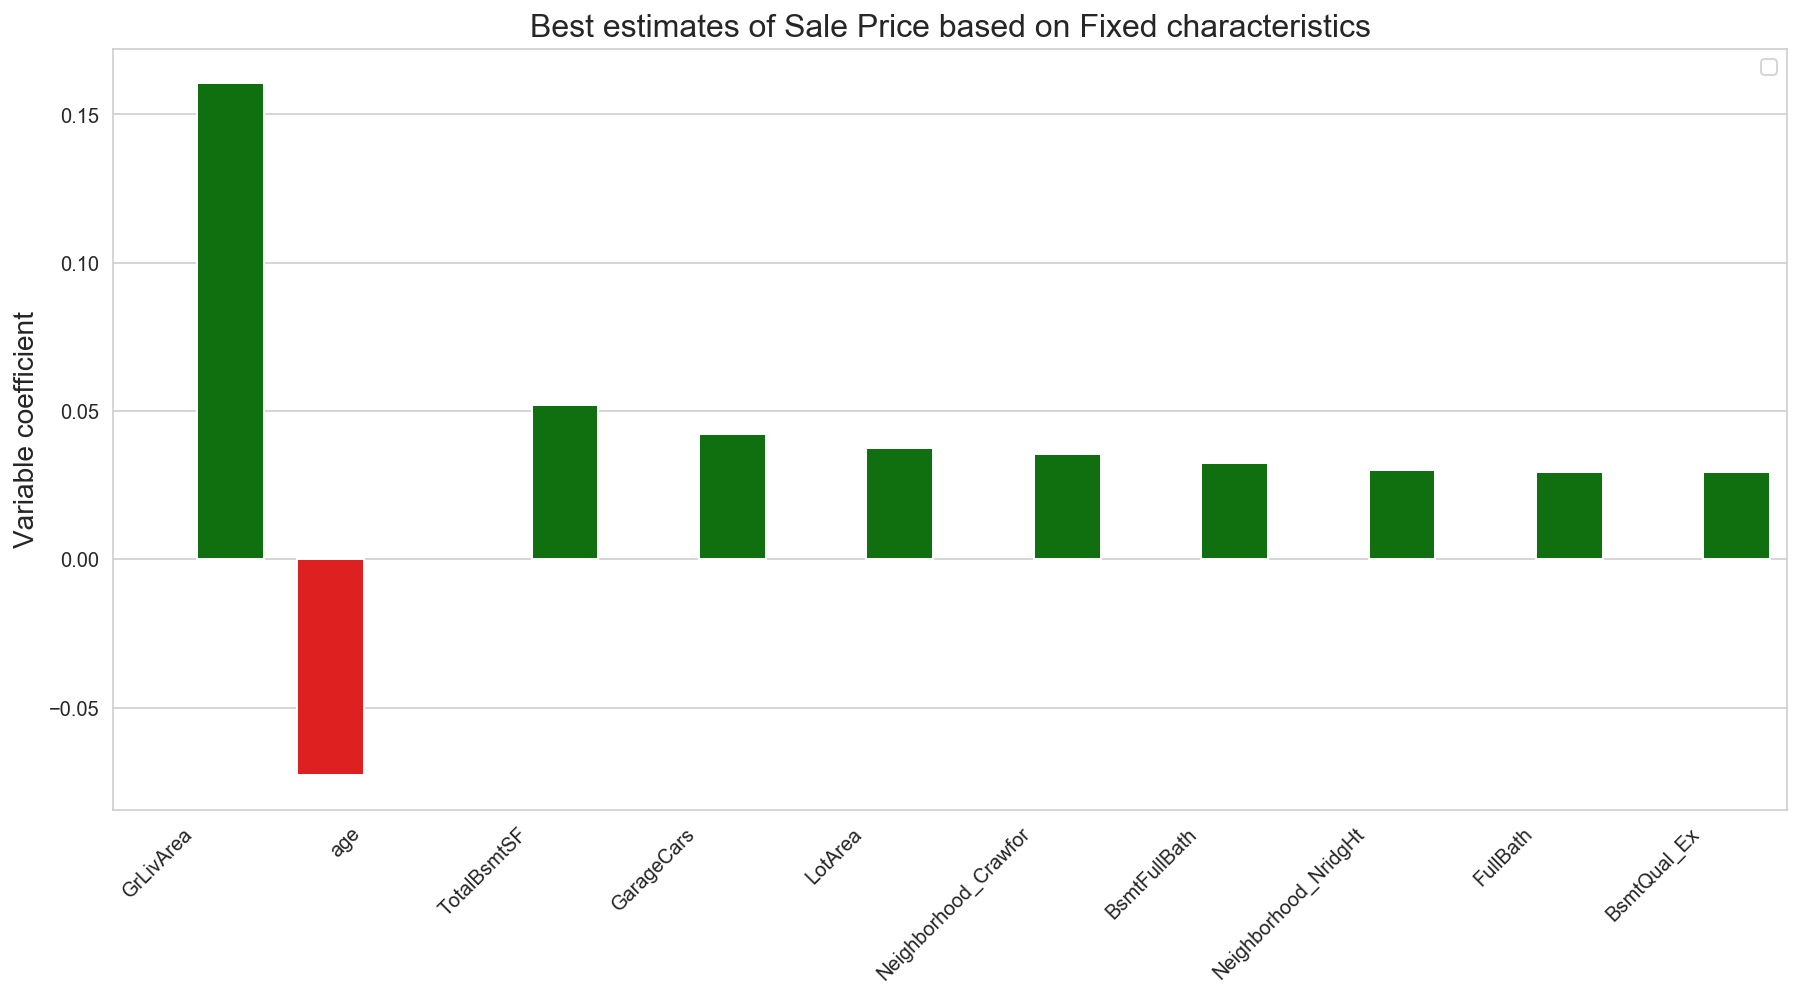

In [182]:
fig,ax = plt.subplots(figsize=(15,7))
sns.barplot(x='variables',y='coefficients',data=lm_ols_reduced_coef.head(10),hue='positive',palette={True:'g',False:'r'})

plt.legend('')
plt.title('Best estimates of Sale Price based on Fixed characteristics', fontsize=16)
plt.xlabel('')
plt.ylabel('Variable coefficient',fontsize=14)
plt.xticks(rotation=45)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.show()

Top 3 predictors of price based on fixed characteristics: ```GrLivArea```, ```age```, ```TotalBsmtSF```

### Model Evaluation on final model

In [183]:
lm_ols_reduced_predictions = lm_ols_reduced.predict(Xs_test_r2)

In [184]:
model_df = pd.DataFrame({
    'y_actual':y_test,
    'y_pred':lm_ols_reduced_predictions
})

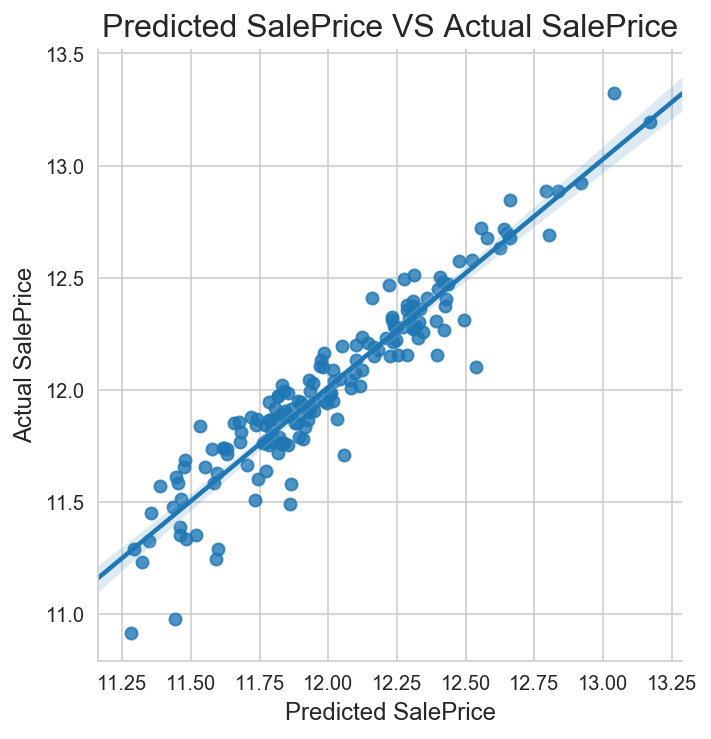

In [185]:
sns.lmplot(x='y_pred', y='y_actual',data=model_df)

plt.title('Predicted SalePrice VS Actual SalePrice',fontsize=16)
plt.xlabel('Predicted SalePrice',fontsize=12)
plt.ylabel('Actual SalePrice',fontsize=12)
plt.show()

In [186]:
lm_ols_reduced_residuals = y_test - lm_ols_reduced_predictions

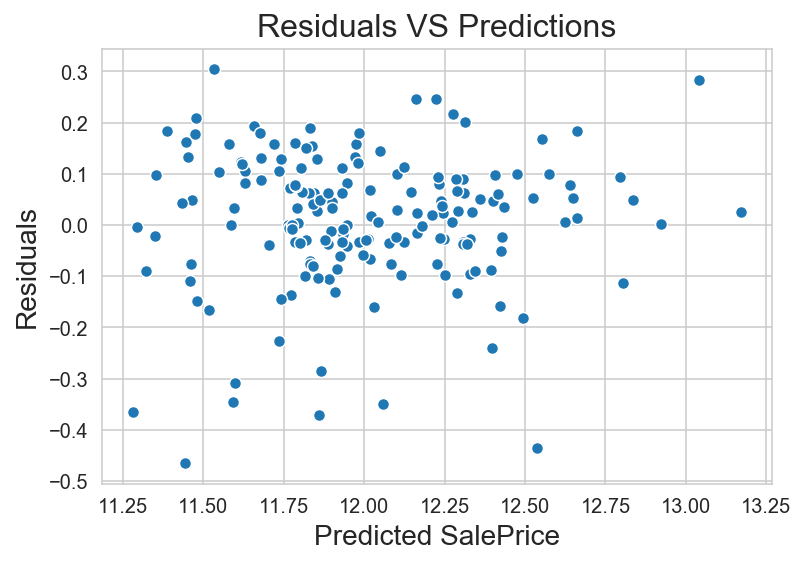

In [187]:
sns.scatterplot(x=lm_ols_reduced_predictions, y=lm_ols_reduced_residuals)

plt.title('Residuals VS Predictions',fontsize=16)
plt.xlabel('Predicted SalePrice', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

plt.show()

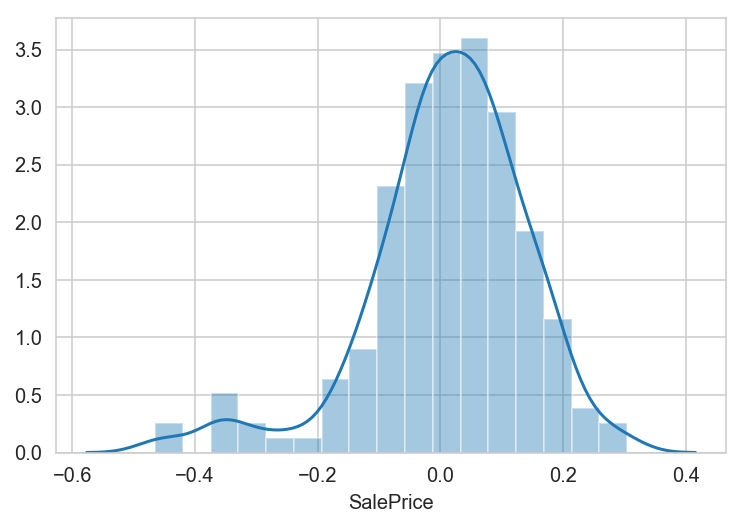

In [188]:
sns.distplot(lm_ols_reduced_residuals)

Residuals are more or less scattered when plotted against predicted values, but are skewed negatively. Will need to tune the model more to ensure that residuals are normally distributed

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: **what are the costs/benefits of quality, condition, and renovations?**

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [189]:
# joining train and test to get Fixed Characteristics Model's (Q1) predictions on SalePrice
Xs_r2 = pd.concat([Xs_train_r2,Xs_test_r2]).reset_index(drop=True)

In [190]:
Xs_r2.shape

(1442, 38)

In [191]:
# getting residuals
saleprice_fixed_preds = lm_ols_reduced.predict(Xs_r2)
saleprice_fixed_preds

array([12.09551002, 12.32285905, 11.76143506, ..., 12.00629732,
       12.33388838, 11.83088857])

In [192]:
# get exponent because the value was logged previously
residuals_fixed = house['SalePrice'] - np.exp(saleprice_fixed_preds)

In [193]:
house_change = house_logtransform.copy()

In [194]:
# adding the residuals to the dataframe
house_change['variance_unexplained_by_fixed'] = residuals_fixed

In [195]:
house_change.sort_values(by='YrSold',inplace=True)
house_change.reset_index(drop=True, inplace=True)

In [196]:
house_change[house_change['YrSold']==2010].head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YrSold,SaleType,SaleCondition,SalePrice,lot_frontage_null,age,remodelled,yrs_since_remod,garage_age,variance_unexplained_by_fixed
1270,635,90,RL,4.174387,8.850804,Pave,NA,Reg,Lvl,AllPub,...,2010,WD,Normal,11.877576,0,30,0,30,30,10497.206956
1271,616,85,RL,4.394449,9.082621,Pave,NA,Reg,Lvl,AllPub,...,2010,WD,Abnorml,11.831386,0,47,0,47,47,-79131.453325


In [197]:
# create new dataframe for modelling Q2
house_change = house_change.drop([col for col in house_change if (col not in changeable) & 
                                                                 (col!='variance_unexplained_by_fixed')],axis=1)

In [198]:
house_change.shape

(1442, 38)

In [199]:
house_change.columns

Index(['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'LowQualFinSF', 'KitchenQual', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence',
       'variance_unexplained_by_fixed'],
      dtype='object')

In [200]:
# for all non numeric columns
# run value_counts and return the most frequently occurring category
change_dummies_to_drop = []
change_dummies_cols = []

for col in house_change.columns:
    if house_change[col].dtype == 'O':
        change_dummies_cols.append(col)
        change_dummies_to_drop.append(col+'_'+house_change[col].value_counts().index[0])

change_dummies_to_drop[:5]

['RoofStyle_Gable',
 'RoofMatl_CompShg',
 'Exterior1st_VinylSd',
 'Exterior2nd_VinylSd',
 'MasVnrType_None']

In [201]:
change_dummies = pd.get_dummies(house_change[change_dummies_cols])
change_dummies.head(2)

,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,...,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_NP,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NFence
0,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
1,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1


In [202]:
change_dummies.drop(change_dummies_to_drop,axis=1,inplace=True)
change_dummies.head(2)

,RoofStyle_Flat,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,...,GarageCond_Po,PavedDrive_N,PavedDrive_P,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [203]:
house_change = pd.concat([house_change,change_dummies],axis=1)
house_change.drop(change_dummies_cols,axis=1, inplace=True)
house_change.head()

,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,Fireplaces,WoodDeckSF,OpenPorchSF,...,GarageCond_Po,PavedDrive_N,PavedDrive_P,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw
0,6,5,0.000000,387,0,374,0,0,0.000000,4.828314,...,0,0,0,0,0,0,0,0,0,0
1,7,5,0.000000,700,0,216,0,0,4.990433,4.521789,...,0,0,0,0,0,0,0,0,0,0
2,4,5,0.000000,0,0,700,0,1,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,5,6,4.174387,360,0,710,0,1,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
4,3,4,0.000000,0,0,1007,0,1,0.000000,4.615121,...,0,0,1,0,0,0,0,0,0,0


In [204]:
house_change.shape

(1442, 131)

#### Get train test data

In [205]:
X_train = house_change[:1270].drop('variance_unexplained_by_fixed',axis=1)
y_train = house_change[:1270]['variance_unexplained_by_fixed']
X_test = house_change[1270:].drop('variance_unexplained_by_fixed',axis=1)
y_test = house_change[1270:]['variance_unexplained_by_fixed']

### Model \#1: Fit everything

In [206]:
# without standardisation
lm_ols = LinearRegression()
lm_ols.fit(X_train,y_train)

cross_val_score(LinearRegression(),X_train,y_train,cv=10).mean()
# YAYZ not so terrible

0.30508879593781507

In [207]:
lm_ols.score(X_test,y_test)

0.3711074238577703

In [208]:
# somehow still performs quite well on test data

In [209]:
# with standardisation
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [210]:
lm_ols.fit(Xs_train, y_train)
cross_val_score(LinearRegression(),pd.DataFrame(Xs_train),y_train,cv=5).mean()

-1.4236078397021851e+27

In [211]:
lm_ols.score(Xs_test,y_test)

-6.906804045934626e+19

### Model \#2: Lasso
Use to reduce the number of features

In [212]:
lm_lasso = LassoCV(n_alphas=100,cv=10)

In [213]:
lm_lasso.fit(Xs_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

Lasso model's test score performed slightly better than OLS model

In [214]:
lm_lasso.score(Xs_train, y_train)

0.44641221121003155

In [215]:
lm_lasso.score(Xs_test,y_test)

0.4105791896664478

In [216]:
lm_lasso_preds = lm_lasso.predict(Xs_test)

In [217]:
lm_lasso.alpha_

5018.512266710988

In [218]:
lm_lasso_coef = pd.DataFrame({
    'coefficients': lm_lasso.coef_,
    'mag': abs(lm_lasso.coef_),
    'variables': X_train.columns
})
lm_lasso_coef.sort_values(by='mag',ascending=False)

,coefficients,mag,variables
0,42419.650411,42419.650411,OverallQual
3,12883.298931,12883.298931,BsmtFinSF1
57,10052.478825,10052.478825,ExterQual_Ex
59,6218.778593,6218.778593,ExterQual_Gd
9,5072.161254,5072.161254,OpenPorchSF
129,-4767.618895,4767.618895,Fence_MnWw
94,4597.168601,4597.168601,KitchenQual_Ex
8,3829.720195,3829.720195,WoodDeckSF
105,2668.258753,2668.258753,FireplaceQu_Gd
7,2362.845305,2362.845305,Fireplaces


In [219]:
lasso_eliminated_features = lm_lasso_coef[lm_lasso_coef['mag']==0]['variables'].values
lasso_eliminated_features

array(['OverallCond', 'MasVnrArea', 'BsmtFinSF2', 'LowQualFinSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'RoofStyle_Flat', 'RoofStyle_Gambrel', 'RoofStyle_Hip',
       'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_Membran',
       'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv',
       'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsbShng',
       'Exterior1st_AsphShn', 'Exterior1st_BrkFace', 'Exterior1st_CBlock',
       'Exterior1st_CemntBd', 'Exterior1st_HdBoard',
       'Exterior1st_ImStucc', 'Exterior1st_MetalSd',
       'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco',
       'Exterior1st_Wd Sdng', 'Exterior2nd_AsbShng',
       'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock',
       'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard',
       'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other',
       'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco',
       'Exterior2nd_Wd Sdng

### Model \#3: SM OLS with reduced features

In [220]:
Xs_train = pd.DataFrame(Xs_train,columns=X_train.columns)
Xs_test = pd.DataFrame(Xs_test,columns=X_test.columns)

In [221]:
remaining_features = [col for col in X_train.columns if col not in lasso_eliminated_features]

In [222]:
Xs_train_r1 = Xs_train[remaining_features]
Xs_test_r1 = Xs_test[remaining_features]

In [223]:
Xs_test_r1.head()

,OverallQual,BsmtFinSF1,BsmtUnfSF,Fireplaces,WoodDeckSF,OpenPorchSF,Exterior1st_BrkComm,Exterior1st_WdShing,Exterior2nd_BrkFace,MasVnrType_Stone,ExterQual_Ex,ExterQual_Gd,BsmtCond_Fa,HeatingQC_TA,KitchenQual_Ex,FireplaceQu_Ex,FireplaceQu_Gd,Fence_MnWw
0,-0.087067,1.431031,-1.280688,-0.969749,1.204334,0.791522,-0.039715,-0.141705,-0.126491,-0.307941,-0.187203,-0.720513,-0.180334,-0.630190,-0.274518,-0.132771,-0.603427,-0.093472
1,-0.087067,0.753743,-0.893890,-0.969749,0.901625,-1.088655,-0.039715,-0.141705,-0.126491,-0.307941,-0.187203,-0.720513,-0.180334,-0.630190,-0.274518,-0.132771,-0.603427,-0.093472
2,-0.087067,-0.926761,1.348643,-0.969749,0.831861,0.369473,-0.039715,-0.141705,-0.126491,-0.307941,-0.187203,-0.720513,-0.180334,-0.630190,-0.274518,-0.132771,-0.603427,-0.093472
3,-0.087067,-0.152388,-0.627827,-0.969749,1.343514,0.590563,-0.039715,-0.141705,-0.126491,3.247377,-0.187203,-0.720513,-0.180334,1.586822,-0.274518,-0.132771,-0.603427,-0.093472
4,0.640401,-1.009977,1.026684,2.184109,0.610963,-1.088655,-0.039715,-0.141705,-0.126491,-0.307941,-0.187203,-0.720513,-0.180334,-0.630190,-0.274518,-0.132771,-0.603427,-0.093472


In [224]:
Xs_train_r1_sm = sm.add_constant(Xs_train_r1) 

In [225]:
# doesnt work for some strange reason >:(
# Xs_test_r1_sm = sm.add_constant(Xs_test_r1)

In [226]:
# adding intercept for Xstest manually instead
Xs_test_r1_sm = Xs_test_r1.copy()

In [227]:
Xs_test_r1_sm['const'] = 1

In [228]:
Xs_test_r1_sm = pd.concat([Xs_test_r1_sm['const'],Xs_test_r1],axis=1)
Xs_test_r1_sm.head()

,const,OverallQual,BsmtFinSF1,BsmtUnfSF,Fireplaces,WoodDeckSF,OpenPorchSF,Exterior1st_BrkComm,Exterior1st_WdShing,Exterior2nd_BrkFace,MasVnrType_Stone,ExterQual_Ex,ExterQual_Gd,BsmtCond_Fa,HeatingQC_TA,KitchenQual_Ex,FireplaceQu_Ex,FireplaceQu_Gd,Fence_MnWw
0,1,-0.087067,1.431031,-1.280688,-0.969749,1.204334,0.791522,-0.039715,-0.141705,-0.126491,-0.307941,-0.187203,-0.720513,-0.180334,-0.630190,-0.274518,-0.132771,-0.603427,-0.093472
1,1,-0.087067,0.753743,-0.893890,-0.969749,0.901625,-1.088655,-0.039715,-0.141705,-0.126491,-0.307941,-0.187203,-0.720513,-0.180334,-0.630190,-0.274518,-0.132771,-0.603427,-0.093472
2,1,-0.087067,-0.926761,1.348643,-0.969749,0.831861,0.369473,-0.039715,-0.141705,-0.126491,-0.307941,-0.187203,-0.720513,-0.180334,-0.630190,-0.274518,-0.132771,-0.603427,-0.093472
3,1,-0.087067,-0.152388,-0.627827,-0.969749,1.343514,0.590563,-0.039715,-0.141705,-0.126491,3.247377,-0.187203,-0.720513,-0.180334,1.586822,-0.274518,-0.132771,-0.603427,-0.093472
4,1,0.640401,-1.009977,1.026684,2.184109,0.610963,-1.088655,-0.039715,-0.141705,-0.126491,-0.307941,-0.187203,-0.720513,-0.180334,-0.630190,-0.274518,-0.132771,-0.603427,-0.093472


In [229]:
Xs_test_r1_sm.shape

(172, 19)

In [230]:
lm_ols_sm = sm.OLS(y_train, Xs_train_r1_sm)

lm_ols_sm = lm_ols_sm.fit()
lm_ols_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     variance_unexplained_by_fixed   R-squared:                       0.469
Model:                                       OLS   Adj. R-squared:                  0.462
Method:                            Least Squares   F-statistic:                     61.44
Date:                           Fri, 12 Oct 2018   Prob (F-statistic):          1.24e-157
Time:                                   03:41:35   Log-Likelihood:                -16119.
No. Observations:                           1270   AIC:                         3.228e+04
Df Residuals:                               1251   BIC:                         3.237e+04
Df Model:                                     18                                         
Covariance Type:                       nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1588.0078   2224.756      0.714      0.475   -2776.657    5952.672
OverallQual          3.318e+04   3706.909      8.952      0.000    2.59e+04    4.05e+04
BsmtFinSF1           2.135e+04   3129.800      6.822      0.000    1.52e+04    2.75e+04
BsmtUnfSF            9816.1863   3179.733      3.087      0.002    3577.988    1.61e+04
Fireplaces           3577.4054   2807.178      1.274      0.203   -1929.891    9084.702
WoodDeckSF           6825.1741   2378.864      2.869      0.004    2158.172    1.15e+04
OpenPorchSF          7233.2127   2563.758      2.821      0.005    2203.473    1.23e+04
Exterior1st_BrkComm -5518.9760   2242.461     -2.461      0.014   -9918.375   -1119.577
Exterior1st_WdShing -4768.6495   2254.595     -2.115      0.035   -9191.855    -345.444
Exterior2nd_BrkFace  5517.0073   2257.508      2.444      0.015    1088.089    9945.926
MasVnrType_Stone     3968.3220   2476.379      1.602      0.109    -889.991    8826.635
ExterQual_Ex         1.324e+04   3046.029      4.347      0.000    7266.130    1.92e+04
ExterQual_Gd         9312.8465   3204.199      2.906      0.004    3026.651    1.56e+04
BsmtCond_Fa         -5286.6975   2269.111     -2.330      0.020   -9738.381    -835.014
HeatingQC_TA        -1746.3474   2481.108     -0.704      0.482   -6613.939    3121.244
KitchenQual_Ex       5185.7024   2846.373      1.822      0.069    -398.489    1.08e+04
FireplaceQu_Ex       4197.4276   2420.707      1.734      0.083    -551.666    8946.522
FireplaceQu_Gd       5199.9281   2828.515      1.838      0.066    -349.229    1.07e+04
Fence_MnWw          -9484.0979   2243.434     -4.227      0.000   -1.39e+04   -5082.790
==============================================================================
Omnibus:                      157.391   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              395.107
Skew:                          -0.682   Prob(JB):                     1.60e-86
Kurtosis:                       5.367   Cond. No.                         3.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [231]:
sm_ols_pvalues = lm_ols_sm.pvalues
sm_ols_pvalues[sm_ols_pvalues.values>0.05].sort_values(ascending=False)

HeatingQC_TA        0.481652
const               0.475490
Fireplaces          0.202766
MasVnrType_Stone    0.109304
FireplaceQu_Ex      0.083170
KitchenQual_Ex      0.068714
FireplaceQu_Gd      0.066241
dtype: float64

In [232]:
sm_ols_eliminated_features = sm_ols_pvalues[sm_ols_pvalues.values>0.05].index[1:]
sm_ols_eliminated_features

Index(['Fireplaces', 'MasVnrType_Stone', 'HeatingQC_TA', 'KitchenQual_Ex',
       'FireplaceQu_Ex', 'FireplaceQu_Gd'],
      dtype='object')

In [233]:
Xs_train_r2 = Xs_train_r1.drop(sm_ols_eliminated_features,axis=1)
Xs_test_r2 = Xs_test_r1.drop(sm_ols_eliminated_features,axis=1)
Xs_train_r2_sm = Xs_train_r1_sm.drop(sm_ols_eliminated_features,axis=1)
Xs_test_r2_sm = Xs_test_r1_sm.drop(sm_ols_eliminated_features,axis=1)

In [234]:
Xs_test_r1_sm.head()

,const,OverallQual,BsmtFinSF1,BsmtUnfSF,Fireplaces,WoodDeckSF,OpenPorchSF,Exterior1st_BrkComm,Exterior1st_WdShing,Exterior2nd_BrkFace,MasVnrType_Stone,ExterQual_Ex,ExterQual_Gd,BsmtCond_Fa,HeatingQC_TA,KitchenQual_Ex,FireplaceQu_Ex,FireplaceQu_Gd,Fence_MnWw
0,1,-0.087067,1.431031,-1.280688,-0.969749,1.204334,0.791522,-0.039715,-0.141705,-0.126491,-0.307941,-0.187203,-0.720513,-0.180334,-0.630190,-0.274518,-0.132771,-0.603427,-0.093472
1,1,-0.087067,0.753743,-0.893890,-0.969749,0.901625,-1.088655,-0.039715,-0.141705,-0.126491,-0.307941,-0.187203,-0.720513,-0.180334,-0.630190,-0.274518,-0.132771,-0.603427,-0.093472
2,1,-0.087067,-0.926761,1.348643,-0.969749,0.831861,0.369473,-0.039715,-0.141705,-0.126491,-0.307941,-0.187203,-0.720513,-0.180334,-0.630190,-0.274518,-0.132771,-0.603427,-0.093472
3,1,-0.087067,-0.152388,-0.627827,-0.969749,1.343514,0.590563,-0.039715,-0.141705,-0.126491,3.247377,-0.187203,-0.720513,-0.180334,1.586822,-0.274518,-0.132771,-0.603427,-0.093472
4,1,0.640401,-1.009977,1.026684,2.184109,0.610963,-1.088655,-0.039715,-0.141705,-0.126491,-0.307941,-0.187203,-0.720513,-0.180334,-0.630190,-0.274518,-0.132771,-0.603427,-0.093472


In [235]:
lm_ols_sm = sm.OLS(y_train, Xs_train_r2_sm)

lm_ols_sm = lm_ols_sm.fit()
lm_ols_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     variance_unexplained_by_fixed   R-squared:                       0.460
Model:                                       OLS   Adj. R-squared:                  0.455
Method:                            Least Squares   F-statistic:                     89.31
Date:                           Fri, 12 Oct 2018   Prob (F-statistic):          8.64e-159
Time:                                   03:41:35   Log-Likelihood:                -16130.
No. Observations:                           1270   AIC:                         3.229e+04
Df Residuals:                               1257   BIC:                         3.235e+04
Df Model:                                     12                                         
Covariance Type:                       nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1588.0078   2238.187      0.710      0.478   -2802.986    5979.002
OverallQual          3.835e+04   3518.077     10.899      0.000    3.14e+04    4.52e+04
BsmtFinSF1           2.351e+04   3067.846      7.664      0.000    1.75e+04    2.95e+04
BsmtUnfSF            1.154e+04   3166.687      3.645      0.000    5330.741    1.78e+04
WoodDeckSF           7439.9189   2379.346      3.127      0.002    2771.992    1.21e+04
OpenPorchSF          6936.1299   2551.463      2.718      0.007    1930.534    1.19e+04
Exterior1st_BrkComm -5495.8006   2255.726     -2.436      0.015   -9921.204   -1070.397
Exterior1st_WdShing -4321.3021   2251.343     -1.919      0.055   -8738.106      95.502
Exterior2nd_BrkFace  6288.1741   2247.681      2.798      0.005    1878.555    1.07e+04
ExterQual_Ex         1.725e+04   2752.634      6.265      0.000    1.18e+04    2.26e+04
ExterQual_Gd         1.036e+04   3093.331      3.351      0.001    4296.031    1.64e+04
BsmtCond_Fa         -5073.2093   2280.668     -2.224      0.026   -9547.545    -598.874
Fence_MnWw          -9640.0296   2252.008     -4.281      0.000   -1.41e+04   -5221.920
==============================================================================
Omnibus:                      148.653   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              381.705
Skew:                          -0.640   Prob(JB):                     1.30e-83
Kurtosis:                       5.361   Cond. No.                         3.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Evaluate the effect in dollars of the renovate-able features
- ```OverallQual``` is the strongest coefficient --> a standard deviation increase in Overall Quality increases the value of the house (not taking into account the fixed characteristics) by $38,345

In [236]:
lm_ols_sm_coeffs = pd.DataFrame(lm_ols_sm.params)

In [237]:
lm_ols_sm_coeffs = lm_ols_sm_coeffs.rename(columns={0:'coefficient'})
lm_ols_sm_coeffs

,coefficient
const,1588.007822
OverallQual,38345.217792
BsmtFinSF1,23511.988595
BsmtUnfSF,11543.315639
WoodDeckSF,7439.918884
OpenPorchSF,6936.129896
Exterior1st_BrkComm,-5495.800621
Exterior1st_WdShing,-4321.302129
Exterior2nd_BrkFace,6288.174143
ExterQual_Ex,17245.413898


#### How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you ahve built to determine if they can make money 
- The company can input the changeable features of a property they're looking to purchase, and the model will predict the Residual / the value of the house not explained by fixed characteristics (the question assumes this to be changeable features)
- If the model predicts a negative residual, it means that the changeable features are bringing down the house value. In this case, the company should purchase the property, renovate it, and flip it at a profit (bearing in mind that the renovation cost should not exceed the value outputted by the model
- If the model predicts a positive value, the house is closer to its actualised price so it might not be worth flipping
- With this model, the company can also put in their targeted renovation level, and see how much more they can earn
- The coefficients of the model also make it possible for the company to calculate the increase in value of the house if say Overall Quality increased from 5-6 or 8-9

#### Investigate how much of the variance in price remaining is explained by these features.

- The model achieved an $R^2$ score of 0.46, indicating that 46% of the variance can be explained by the changeable features

#### Do you trust your model? Should it be used to evaluate which properties to buy and fix up?
- Not at this point. $R^2$ score is still pretty low (but better than predicting the mean). Additionally, both models do not take into account other factors like Sale condition and seasonality (some months sell better)
- Additionally, based on the residual plot below, there seems to be some relationship between the residuals and the predicted values, which indicate that there are some underlying relationships between variables and between variables and the target variable that have not been accounted for in this model

In [238]:
Xs_train_r2_sm.shape

(1270, 13)

In [239]:
lm_ols_sm_predictions = lm_ols_sm.predict(Xs_test_r2_sm)

In [240]:
lm_ols_sm_results = pd.DataFrame({
    'Actual Y': y_test.values,
    'Predicted Y': lm_ols_sm_predictions
})

lm_ols_sm_results['Residuals'] = lm_ols_sm_results['Actual Y'] - lm_ols_sm_results['Predicted Y']
lm_ols_sm_results.head()

,Actual Y,Predicted Y,Residuals
0,10497.206956,22717.524391,-12220.317435
1,-79131.453325,-4035.200347,-75096.252978
2,-17176.270806,-8066.195907,-9110.074899
3,77623.715653,-7334.002072,84957.717725
4,-4576.637858,2398.426071,-6975.063929


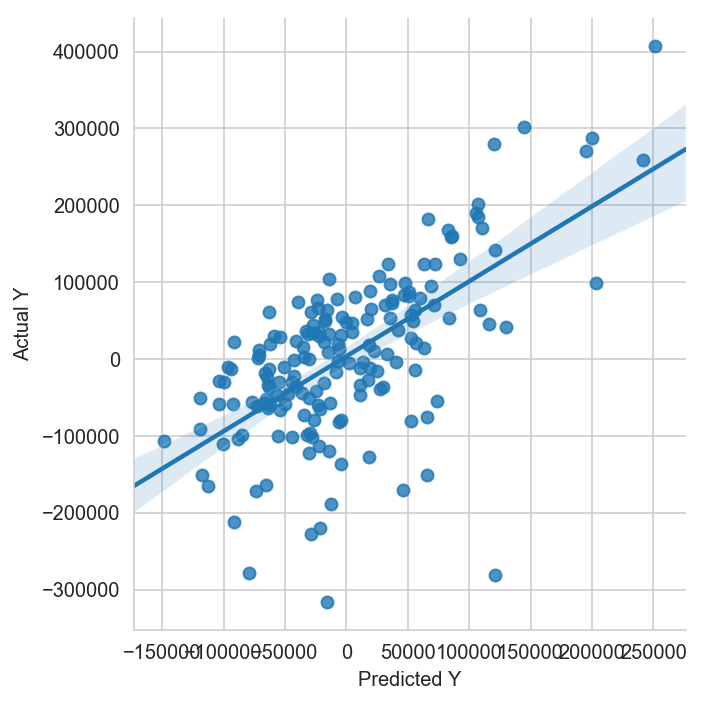

In [241]:
sns.lmplot(x='Predicted Y', y='Actual Y', data=lm_ols_sm_results)

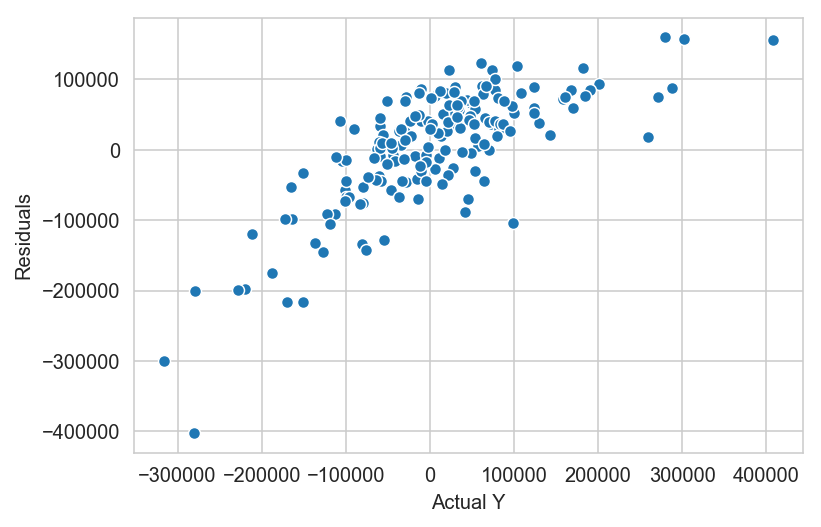

In [242]:
sns.scatterplot(x='Actual Y', y='Residuals', data=lm_ols_sm_results)

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [243]:
# A: